<a href="https://colab.research.google.com/github/tokyo8182/MindGuardian_LLM/blob/main/data_import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mind Guardian - Omdena Local Chapter Challange


## Data Analysis

Load the libraries.


In [2]:
pip install python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 1.4 MB/s eta 0:00:00


In [4]:
pip install PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 28.1 MB/s eta 0:00:00


In [6]:
pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.4 MB/s eta 0:00:00


In [7]:
import pandas as pd
import json
from docx import Document
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import fitz
import torch
import re
from re import sub
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import chardet
import os
import contractions

plt.style.use("seaborn-v0_8-dark-palette")

Loading `stopwords` from the `nltk` library


In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmedr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Functions for Reading and Cleaning the Data


In [ ]:
# Load data into a single string
def read_data(file_path):
    # Check the file extension and read the content accordingly
    if file_path.endswith(".csv"):
        text = pd.read_csv(file_path).to_string()
    elif file_path.endswith(".txt"):
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
    elif file_path.endswith(".xlsx"):
        text = pd.read_excel(file_path).to_string()
    elif file_path.endswith(".json"):
        with open(file_path, "r", encoding="utf-8") as file:
            # Attempt to handle both regular JSON and newline-delimited JSON
            try:
                data = json.load(file)
                text = json.dumps(data)
            except json.JSONDecodeError:
                file.seek(0)  # reset file pointer to start
                lines = file.readlines()
                text = " ".join([line.strip() for line in lines])
    elif file_path.endswith(".docx"):
        doc = Document(file_path)
        text = "\n".join(para.text for para in doc.paragraphs)
    elif file_path.endswith(".pdf"):
        doc = fitz.open(file_path)
        text = "".join(page.get_text() for page in doc)
        doc.close()
    else:
        raise ValueError("Unsupported file type provided, must be one of .csv, .txt, .xlsx, .json, .docx, .pdf")

    # Clean the extracted text
    return clean_text(text)


#  Load data into a pandas dataframe
def read_data_df(file_path):
    # Check the file extension and load data accordingly
    if file_path.endswith(".csv"):
        df = pd.read_csv(file_path)
    elif file_path.endswith(".xlsx"):
        df = pd.read_excel(file_path)
    elif file_path.endswith(".json"):
        try:
            # Attempt to read standard JSON file
            with open(file_path, "r", encoding="utf-8") as file:
                data = json.load(file)
                df = pd.DataFrame(data)
        except json.JSONDecodeError:
            # Handle JSON Lines (newline-delimited JSON)
            with open(file_path, "r", encoding="utf-8") as file:
                data = [json.loads(line.strip()) for line in file if line.strip()]
                df = pd.DataFrame(data)
    else:
        raise ValueError("Unsupported file type provided")

    def snake(s):
        return "_".join(sub("([A-Z][a-z]+)", r" \1", sub("([A-Z]+)", r" \1", s.replace("-", " "))).split()).lower()

    df.columns = [snake(col) for col in df.columns]

    # Clean the extracted text
    for column in df.columns:
        if df[column].dtype == object:  # Check if the column is of type object
            df[column] = df[column].fillna("").str.strip().apply(clean_text)
    return df


# Clean the text
def clean_text(text):
    if isinstance(text, str):
        text = contractions.fix(text)
        text = re.sub(r"\d+(?![\d\ \,\.\:\;\)\-\%\st\nd\rd\th])", "", text)
        text = re.sub(r"[^a-zA-Z0-9\.\,\(\)\-\'\"\%\s]|[\t\r\n]+|(et al.)", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
    return text

### Text Analysis Functions


In [ ]:
# Word Cloud Generation
def generate_word_cloud(input_data, column=None):
    if isinstance(input_data, pd.DataFrame) and column:
        # Concatenate all text in the specified column
        text = " ".join(input_data[column].dropna().astype(str))
        text = text.replace("'", "")
    elif isinstance(input_data, str):
        text = input_data
        input_data = input_data.replace("'", "")
    else:
        raise ValueError("Input should be a string or a DataFrame with a specified column.")

    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", stopwords=CUSTOM_STOP_WORDS, collocations=False
    ).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# Common Word Counts
def common_word_counts(input_data, column=None, n=10):
    if isinstance(input_data, pd.DataFrame) and column:
        # Concatenate all text in the specified column
        text = " ".join(input_data[column].dropna().astype(str))
        text = text.replace("'", "")
    elif isinstance(input_data, str):
        text = input_data
        input_data = input_data.replace("'", "")
    else:
        raise ValueError("Input should be a string or a DataFrame with a specified column.")

    # Remove punctuation and numbers
    text = re.sub(r"[^\w\s]", "", text)  # Removes punctuation
    text = re.sub(r"\d+", "", text)  # Removes digits

    # Filter words by length >= 3 and not in stop words
    words = [word for word in text.split() if len(word) >= 3 and word.lower() not in CUSTOM_STOP_WORDS]

    # Count the words
    word_counts = Counter(words)

    return word_counts.most_common(n)


# Keyword Extraction
def extract_keywords(input_data, column=None, n=10):
    if isinstance(input_data, pd.DataFrame) and column:
        # Concatenate all text in the specified column
        text = " ".join(input_data[column].dropna().astype(str))
        text = text.replace("'", "")
    elif isinstance(input_data, str):
        text = text.replace("'", "")
        text = input_data
    else:
        raise ValueError("Input should be a string or a DataFrame with a specified column.")

    # Define a custom tokenizer that ignores punctuation, numbers, and short words
    tokenizer = lambda x: re.findall(r"\b\w{3,}\b", x)

    # Create the vectorizer
    vectorizer = CountVectorizer(max_features=n, stop_words="english", tokenizer=tokenizer)

    # Fit and transform the text
    X = vectorizer.fit_transform([text])

    # Get the keywords
    keywords = vectorizer.get_feature_names_out()

    return keywords


# Define a function to calculate and plot word correlation matrix
def plot_word_correlation_matrix(input_data, column=None, n=10):
    if isinstance(input_data, pd.DataFrame) and column:
        # Concatenate all text in the specified column
        text = " ".join(input_data[column].dropna().astype(str))
    elif isinstance(input_data, str):
        text = input_data
    else:
        raise ValueError("Input should be a string or a DataFrame with a specified column.")

    # Preprocess text to replace apostrophes with no space
    text = text.replace("'", "")

    documents = [text]  # Wrap the text in a list

    # Define a custom tokenizer that ignores punctuation, numbers, and short words
    tokenizer = lambda x: re.findall(r"\b\w{3,}\b", x)

    # Create the vectorizer
    vectorizer = CountVectorizer(stop_words="english", tokenizer=tokenizer)

    # Fit and transform the text
    X = vectorizer.fit_transform(documents)
    Xc = X.T * X
    Xc = Xc.toarray()
    np.fill_diagonal(Xc, 0)  # Initially, clear the diagonal

    # Normalize the co-occurrence matrix to range from 0 to 1
    Xc_norm = Xc / Xc.max()

    # Set diagonal values to 1
    np.fill_diagonal(Xc_norm, 1)

    # Create the DataFrame
    correlation_df = pd.DataFrame(
        Xc_norm, index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out()
    )

    # Calculate the correlation strength
    correlation_strength = correlation_df.abs().sum().sort_values(ascending=False)

    # Select the top 'n' words with the highest correlation sum
    top_n_words = correlation_strength.head(n).index

    # Filter the DataFrame to only include these top 'n' words
    filtered_correlation_df = correlation_df.loc[top_n_words, top_n_words]

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(filtered_correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": 0.5}, square=True)

    plt.title("Word Correlation Matrix - {} - Top {} Words".format(column, n))
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
    plt.show()


def plot_word_correlation_graph(input_data, column=None, n=10):
    if isinstance(input_data, pd.DataFrame) and column:
        # Concatenate all text in the specified column
        text = " ".join(input_data[column].dropna().astype(str))
    elif isinstance(input_data, str):
        text = input_data
    else:
        raise ValueError("Input should be a string or a DataFrame with a specified column.")

    # Preprocess text to replace apostrophes with no space
    text = text.replace("'", "")

    documents = [text]  # Wrap the text in a list

    # Define a custom tokenizer that ignores punctuation, numbers, and short words
    tokenizer = lambda x: re.findall(r"\b\w{3,}\b", x)

    # Create the vectorizer
    vectorizer = CountVectorizer(stop_words="english", tokenizer=tokenizer)

    # Fit and transform the text
    X = vectorizer.fit_transform(documents)
    Xc = X.T * X
    Xc = Xc.toarray()
    np.fill_diagonal(Xc, 0)  # Initially, clear the diagonal

    # Normalize the co-occurrence matrix to range from 0 to 1
    Xc_norm = Xc / Xc.max()

    # Set diagonal values to 1
    np.fill_diagonal(Xc_norm, 1)

    # Create the DataFrame
    correlation_df = pd.DataFrame(
        Xc_norm, index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out()
    )

    # Calculate the correlation strength
    correlation_strength = correlation_df.abs().sum().sort_values(ascending=False)

    # Select the top 'n' words with the highest correlation sum
    top_n_words = correlation_strength.head(n).index

    # Filter the DataFrame to only include these top 'n' words
    filtered_correlation_df = correlation_df.loc[top_n_words, top_n_words]

    # Create a graph using NetworkX
    G = nx.Graph()

    # Add edges with weights to the graph
    for i in range(len(top_n_words)):
        for j in range(i + 1, len(top_n_words)):
            if filtered_correlation_df.iloc[i, j] > 0:  # Only add edges with positive correlation
                G.add_edge(top_n_words[i], top_n_words[j], weight=filtered_correlation_df.iloc[i, j])

    # Scale the figure size based on n
    plt.figure(figsize=(n - 5, n - 5))

    # Draw the graph
    pos = nx.spring_layout(G, seed=42)  # Position nodes using the Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold")

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}  # Format edge labels to two decimal places
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Word Correlation Graph - {} - Top {} Words".format(column, n))
    plt.show()

### The Initial Data Set

Lets take a look at the data.


#### Mental Health Counselling Conversation Data


In [ ]:
df1 = read_data_df("../assets/json/mental_health_counseling_conversations.json")
# Display the DataFrame
df1.head()

context  \
0  I am going through some things with my feeling...   
1  I am going through some things with my feeling...   
2  I am going through some things with my feeling...   
3  I am going through some things with my feeling...   
4  I am going through some things with my feeling...   

                                            response  
0  If everyone thinks you are worthless, then may...  
1  Hello, and thank you for your question and see...  
2  First thing I would suggest is getting the sle...  
3  Therapy is essential for those that are feelin...  
4  I first want to let you know that you are not ...

#### Description of the Data


In [ ]:
df1.describe()

context response
count                                                3512     3512
unique                                                831     2024
top     I have so many issues to address. I have a his...         
freq                                                   94        5

We have 3512 rows and 2 columns in the data. The columns are:

-   `Context`: A contextual input from a person feeling anxiuos or depressed.
-   `Response`: A response from a mental health professional.

We only have 831 unique contexts and 2024 unique responses. We will need to clean the data to get rid of the duplicates.


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   3512 non-null   object
 1   response  3512 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


We have no `null` values.


#### Keywords

##### Context Keywords


In [ ]:
extract_keywords(df1, column="context").tolist()

c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['does',
 'feel',
 'just',
 'know',
 'like',
 'really',
 'relationship',
 'time',
 'want',
 'years']

##### Response Keywords


In [ ]:
extract_keywords(df1, column="response").tolist()

c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['feel',
 'help',
 'know',
 'like',
 'people',
 'relationship',
 'therapist',
 'time',
 'want',
 'way']

#### Word Counts

##### Context


In [ ]:
CUSTOM_STOP_WORDS = set(stopwords.words("english")).union({"."})
common_word_counts(df1, column="context")

[('feel', 1223),
 ('like', 1150),
 ('know', 974),
 ('get', 875),
 ('want', 774),
 ('years', 657),
 ('time', 627),
 ('never', 623),
 ('cannot', 610),
 ('always', 509)]

##### Response


In [ ]:
common_word_counts(df1, column="response")

[('may', 2870),
 ('would', 2781),
 ('feel', 2714),
 ('help', 2296),
 ('like', 2236),
 ('relationship', 1991),
 ('time', 1916),
 ('people', 1718),
 ('therapist', 1676),
 ('way', 1611)]

#### Word Clouds

This gives us a great first insight to the data. We can visualise the most common words in the data.

##### Context


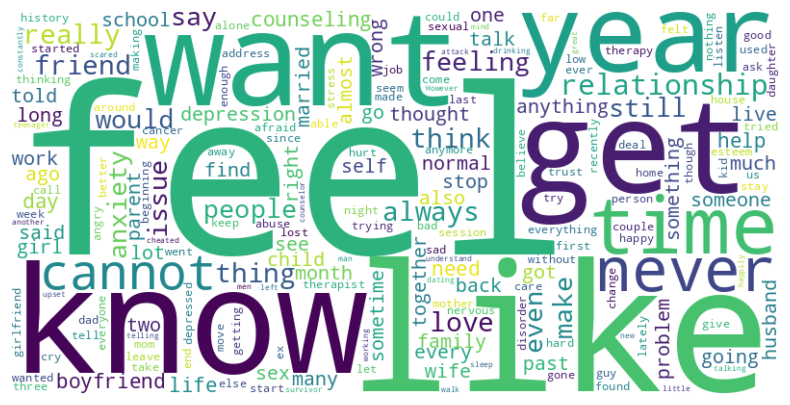

In [ ]:
CUSTOM_STOP_WORDS = set(stopwords.words("english")).union({"."})
generate_word_cloud(df1, column="context")

##### Response


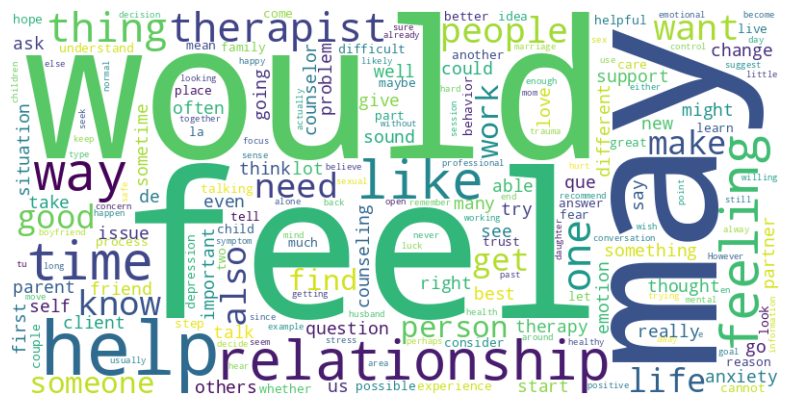

In [ ]:
CUSTOM_STOP_WORDS = set(stopwords.words("english")).union({"."})
generate_word_cloud(df1, column="response")

#### Correlation Matrix

##### Context


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


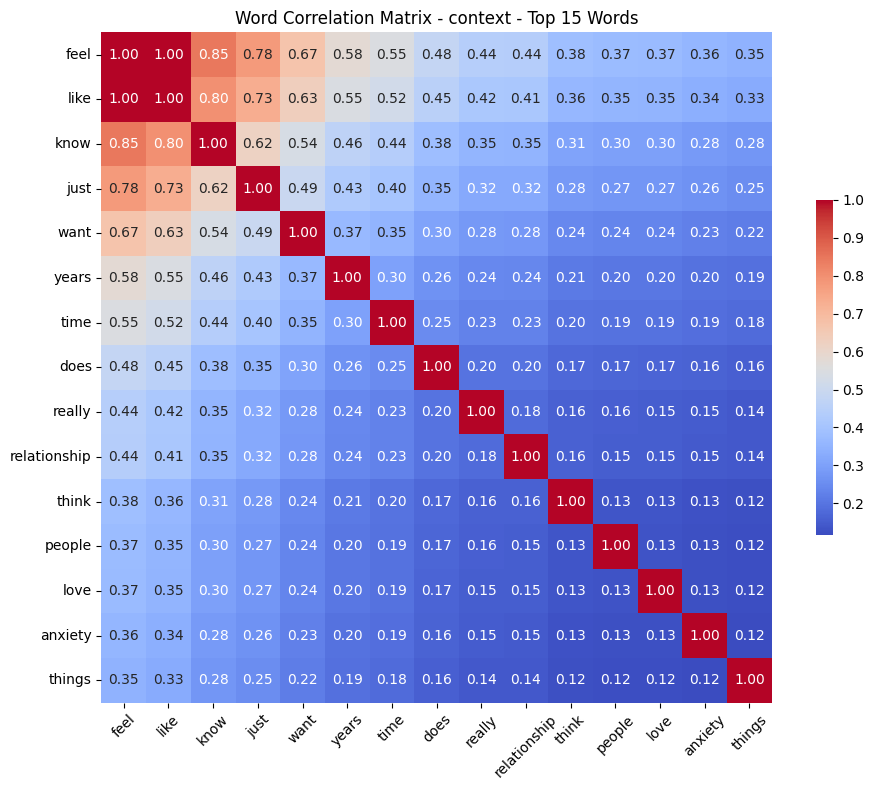

In [ ]:
plot_word_correlation_matrix(df1, column="context", n=15)

##### Response


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


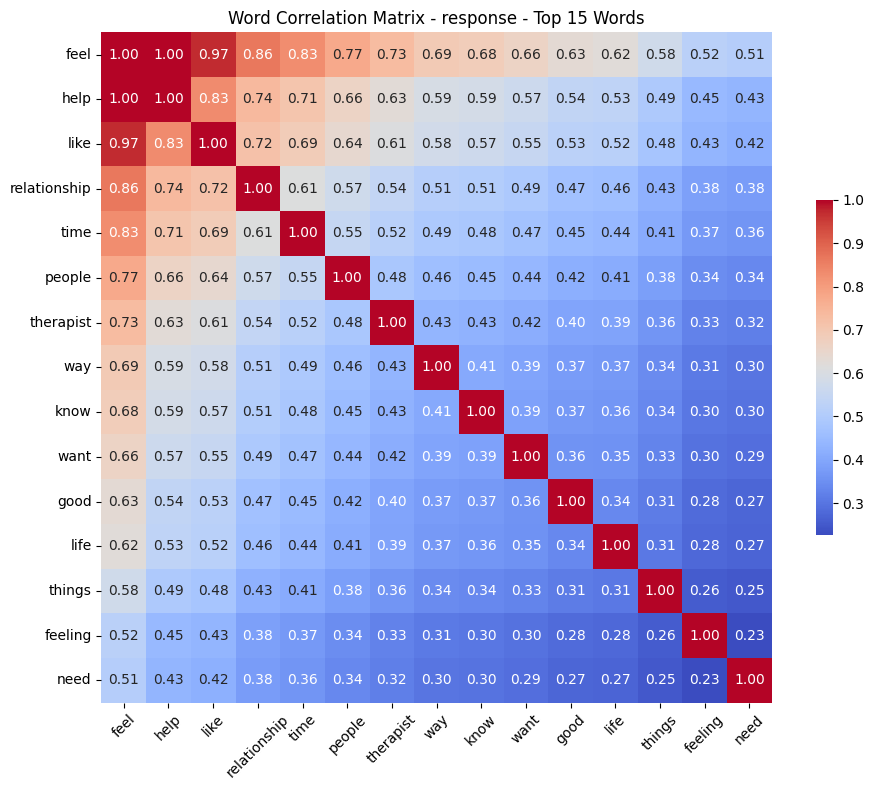

In [ ]:
plot_word_correlation_matrix(df1, column="response", n=15)

#### Correlation Graph

##### Context


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


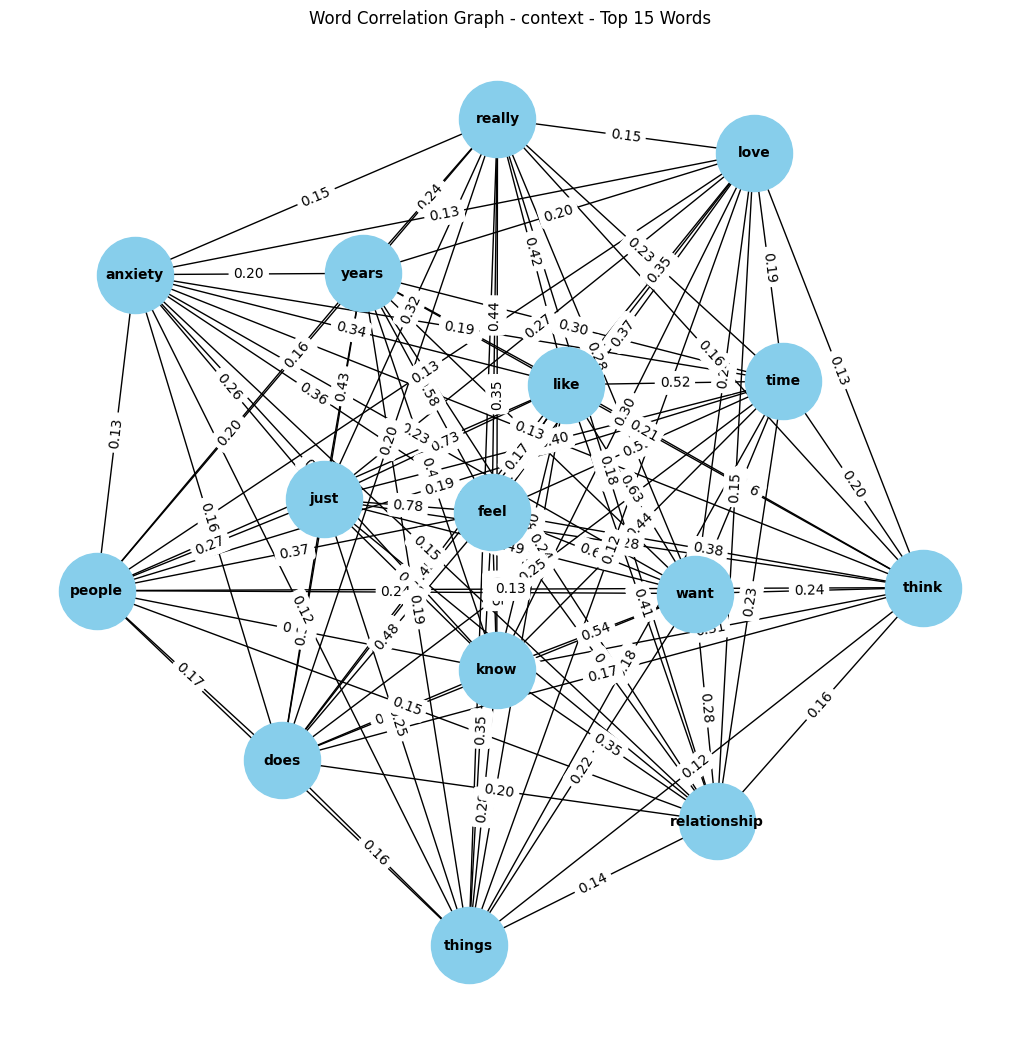

In [ ]:
plot_word_correlation_graph(df1, column="context", n=15)

##### Response


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


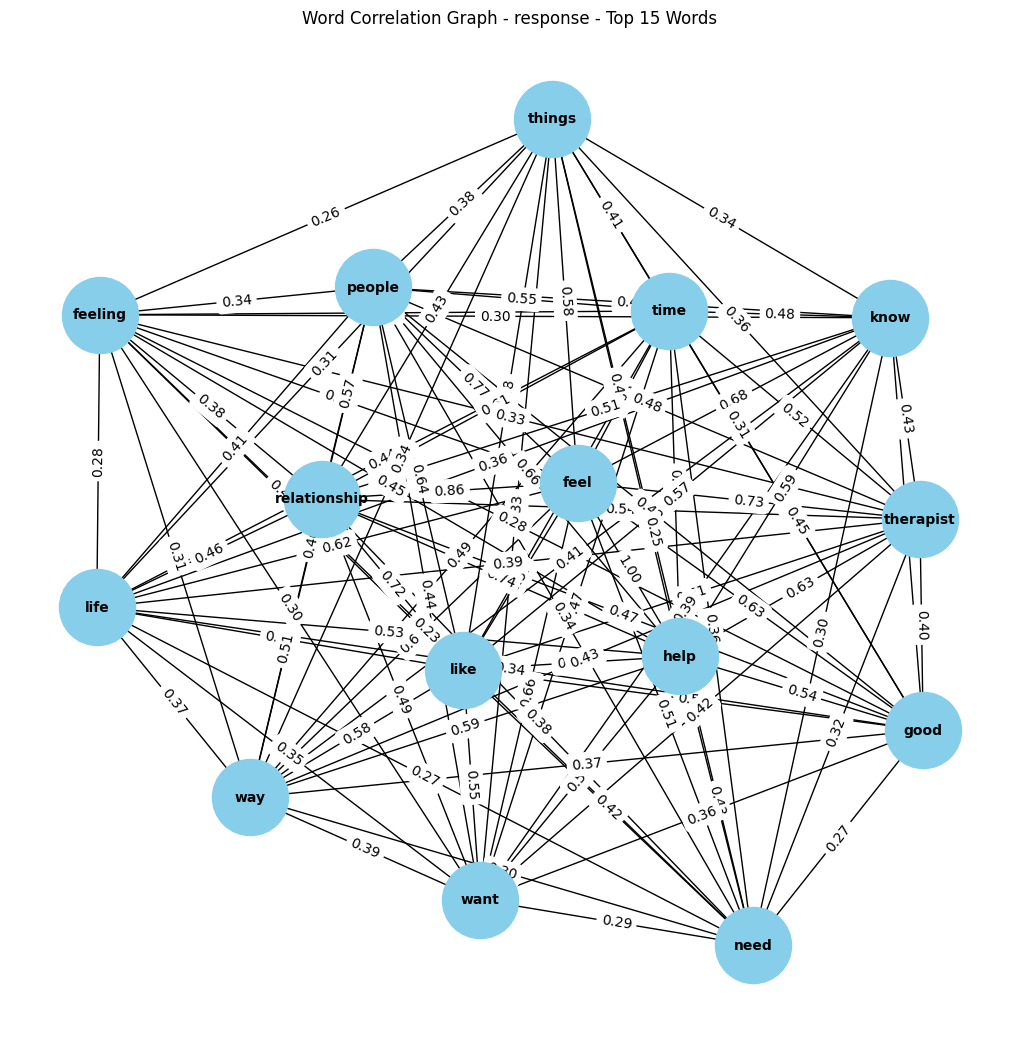

In [ ]:
plot_word_correlation_graph(df1, column="response", n=15)

#### Aggregation

We can see from from the initial anlysis that the data has duplicates in both the `Context` column and the `Response` column. We will need to clean the data before we can do any further analysis.  
Instead of removing all the duplicates, we will aggregate the data. We will group the data by the `Context` column and then aggregate the `Response` column. This will give us a unique `Context` column with all the `Response` columns aggregated. We will still have some duplicates in the `Response` column, but we will have a unique `Context` column. This will reduce the number of rows in the data from 3512 to 831.


In [ ]:
aggregated_df1 = df1.groupby("context")["response"].apply(" ".join).reset_index()
aggregated_df1.head()

context  \
0  A few nights ago I talked to this girl I know ...   
1  A few years ago I was making love to my wife w...   
2  A friend of mine taking psychology advised I g...   
3  A girl and I were madly in love. We dated for ...   
4  A lot of times, I avoid situations where I am ...   

                                            response  
0  Hey It takes a lot of courage to share your fe...  
1  First step always is to do a medical rule out ...  
2  I admire your courage for stating your view ab...  
3  Hi Boise, I am sorry that you have lost this l...  
4  Hello, and thank you for your question. First,...

After aggregating the data, we only have one duplicate in the `Response` column.


In [ ]:
aggregated_df1.describe()

context  \
count                                                 831   
unique                                                831   
top     A few nights ago I talked to this girl I know ...   
freq                                                    1   

                                                 response  
count                                                 831  
unique                                                830  
top     One way to concentrate is that if your mind st...  
freq                                                    2

In [ ]:
duplicate_values = aggregated_df1[aggregated_df1.duplicated(subset="response", keep=False)]
duplicate_values

context  \
232       I cannot understand what I pay attention to.   
414  I have pretty much been on my own since day on...   

                                              response  
232  One way to concentrate is that if your mind st...  
414  One way to concentrate is that if your mind st...

#### Correlation Matrix After Aggregation

##### Context


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


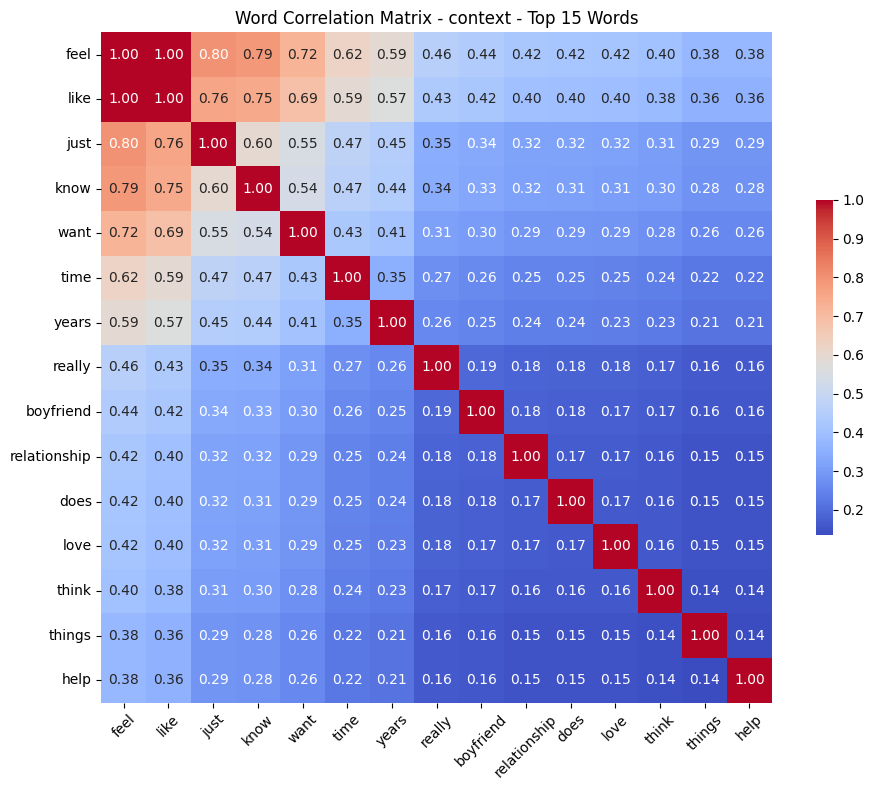

In [ ]:
plot_word_correlation_matrix(aggregated_df1, column="context", n=15)

##### Response


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


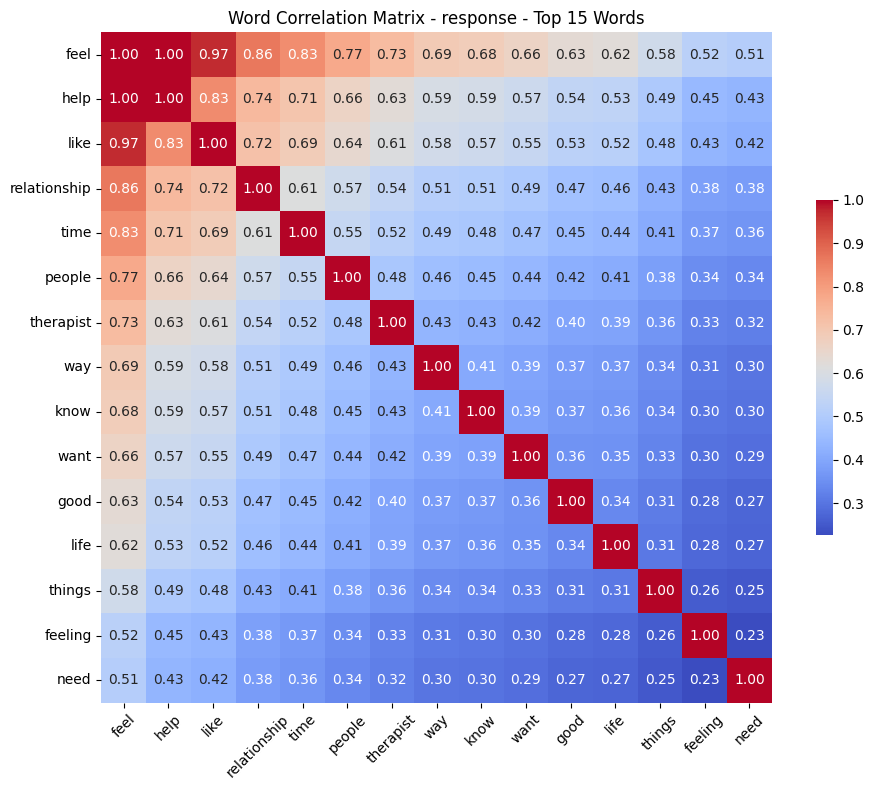

In [ ]:
plot_word_correlation_matrix(aggregated_df1, column="response", n=15)

#### Correlation Graph After Aggregation

##### Context


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


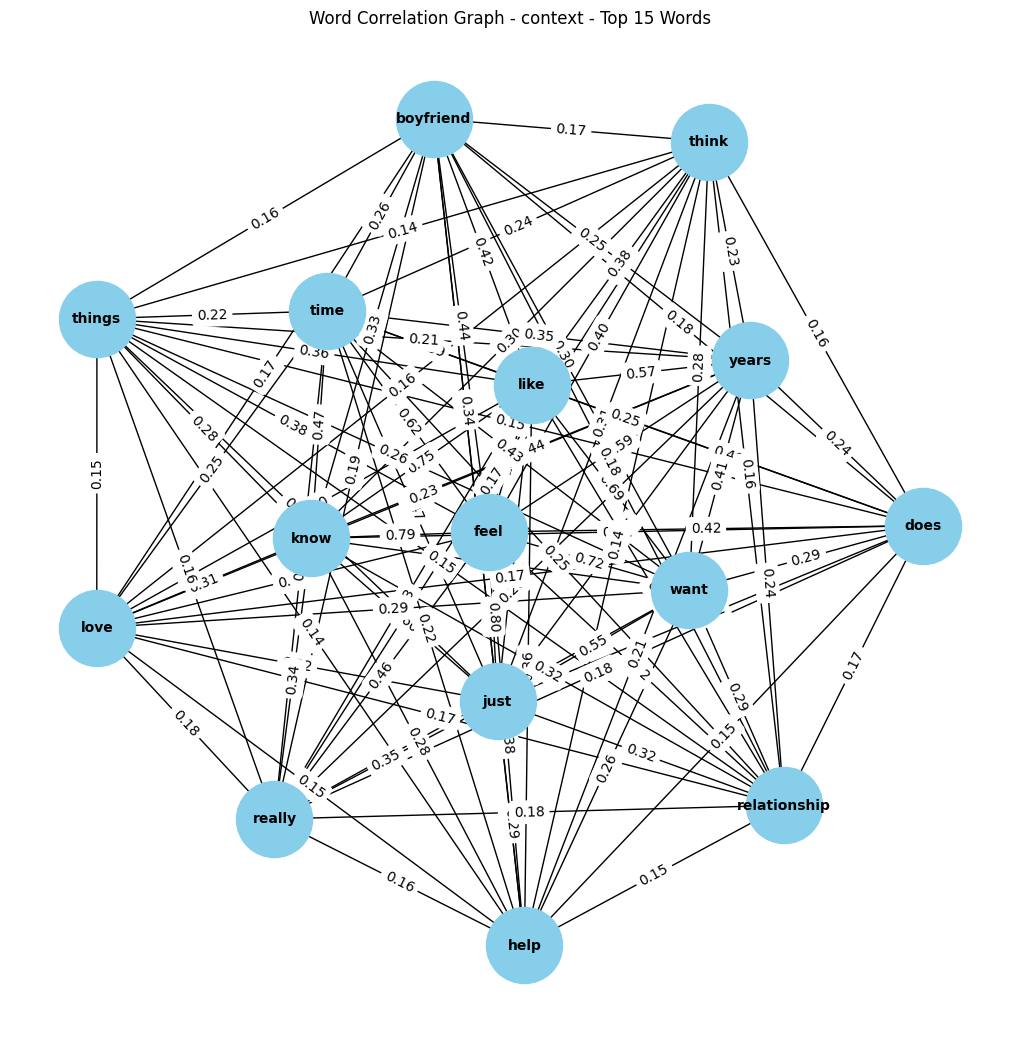

In [ ]:
plot_word_correlation_graph(aggregated_df1, column="context", n=15)

##### Response


c:\Users\kmedr\My Drive\Top_Talent\WorldUniversityofBangladesh_MindGuardian\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


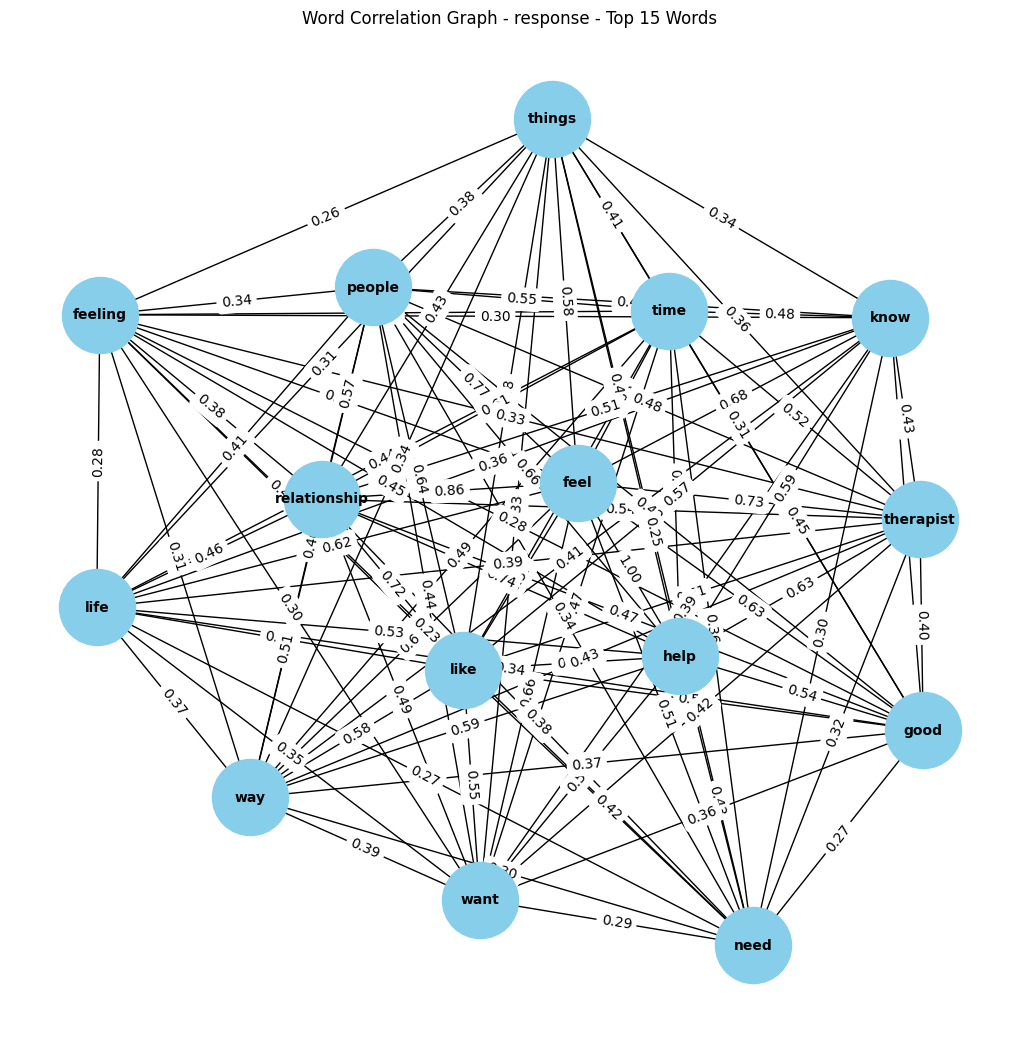

In [ ]:
plot_word_correlation_graph(aggregated_df1, column="response", n=15)

## Sentiment Analysis


### Sentiment Analysis Functions


In [ ]:
# Tokenization of Text Data
def segment_text(text, max_length, overlap):
    tokens = tokenizer.tokenize(text)
    length = len(tokens)
    segments = []

    # print(f"Total tokens: {length}")  # Debugging output

    if length <= max_length:
        segments.append(text)
    else:
        start = 0
        while start < length:
            end = min(start + max_length, length)
            segment = tokens[start:end]
            segment_text = tokenizer.convert_tokens_to_string(segment)
            segments.append(segment_text)
            # print(f"Segment from {start} to {end}: {segment_text[:100]}...")  # Debugging output
            start += max_length - overlap

    return segments


# Sentiment Analysis with Transformers on whole text output
def analyze_transformers(data, columns=None, max_length=462, overlap=50):

    if isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        for column in columns:
            # Process text in segments with overlap
            data_copy[f"{column}_sentiment"] = data_copy[column].apply(
                lambda text: [classifier(segment) for segment in segment_text(text, max_length, overlap)]
            )
        return data_copy

    elif isinstance(data, str):
        # Directly classify text if not a DataFrame
        segments = segment_text(data, max_length, overlap)
        result = []
        for segment in segments:
            if segment.strip():  # Ensure segment is not empty
                print(f"Classifying segment: {segment[:100]}...")  # Debugging output
                result.append(classifier(segment))
            else:
                print("Skipping empty segment")
        return result
    else:
        raise TypeError("Data must be a pandas DataFrame or a string")


# Sentiment Analysis with Transformers on sentances
def analyze_transformers_sentances(data, columns=None):

    if isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        for column in columns:
            # Process text in segments with spaCy and apply sentiment analysis
            data_copy[f"{column}_sentiment"] = data_copy[column].apply(
                lambda text: [
                    {"sentiment": classifier(sentence.text)[0]["label"], "score": classifier(sentence.text)[0]["score"]}
                    for sentence in nlp(text).sents
                ]
            )
        return data_copy
    elif isinstance(data, str):
        doc = nlp(data)
        result = [classifier(sentence.text) for sentence in doc.sents]
        return result
    else:
        raise TypeError("Data must be a pandas DataFrame or a string")


# Lexicon-based Sentiment Analysis
def analyze_textblob(data, columns=None):

    if isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        for column in columns:
            data_copy[f"{column}_polarity"] = data[column].apply(lambda x: TextBlob(x).sentiment.polarity)
            data_copy[f"{column}_subjectivity"] = data[column].apply(lambda x: TextBlob(x).sentiment.subjectivity)
        return data_copy
    elif isinstance(data, str):
        sentiment = TextBlob(data).sentiment
        return sentiment.polarity, sentiment.subjectivity
    else:
        raise TypeError("Data must be a pandas DataFrame or a string")


# Sentiment Analysis with VADER
def analyze_vader(data, columns=None):

    if isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        for column in columns:
            data_copy[f"{column}_scores"] = data_copy[column].apply(lambda x: sia.polarity_scores(x))
        return data_copy
    elif isinstance(data, str):
        sentiment_scores = sia.polarity_scores(data)
        return sentiment_scores
    else:
        raise TypeError("Data must be a pandas DataFrame or a string")


# Visualize the Lexicon-based Sentiment Analysis
def visualise_textblob(df, column1, column2, column3, column4):
    plt.figure(figsize=(10, 5))
    plt.hist(df[column1], bins=50, alpha=0.7, label=f"{column1}", color="y")
    plt.hist(df[column2], bins=50, alpha=0.7, label=f"{column2}", color="r")
    plt.hist(df[column3], bins=50, alpha=0.7, label=f"{column3}", color="b")
    plt.hist(df[column4], bins=50, alpha=0.7, label=f"{column4}", color="g")
    plt.xlabel("Scores")
    plt.ylabel("Frequency")
    plt.title("Distribution of Polarity and Subjectivity")
    plt.legend()
    plt.show()


# Visualize the VADER Sentiment Analysis
def visualise_vader(df, column, color):
    plt.figure(figsize=(10, 5))
    plt.hist(df[column].apply(lambda x: x["compound"]), bins=50, color=color)
    plt.xlabel("Compound Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of VADER Compound Scores - Context")
    plt.show()

### Lexicon Based Sentiment Analysis


**Methodology:**

Lexicon-based sentiment analysis involves using a dictionary or a lexicon of words that are labeled as positive, negative, or neutral, along with their intensity scores. The basic idea is to compute the sentiment of a text by tallying the sentiment scores of the words that appear in the text. Here's a breakdown of the approach:

-   **Lexicon Preparation**: A comprehensive list of sentiment words is prepared where each word is assigned a sentiment polarity (positive, negative, neutral) and sometimes a weight (strength of sentiment).
-   **Text Processing**: The text is tokenized into words, and common preprocessing steps are applied.
-   **Sentiment Calculation**: Each word in the text is checked against the lexicon. The sentiment scores of the words are aggregated to derive an overall sentiment score for the entire text.
-   **Adjustments**: Modifications might be made based on the context, negations (e.g., "not good"), intensifiers (e.g., "very good"), and diminishers (e.g., "somewhat good").

**Key Features of Lexicon-Based Sentiment Analysis:**

-   **Sentiment Lexicon:** Utilises a comprehensive dictionary of sentiment-laden words and phrases, each tagged with a specific sentiment score.
-   **Rule-Based:** Incorporates rules for adjusting sentiment scores based on context, such as negations or intensifiers (e.g., "not good" versus "very good").
-   **No Training Required:** Unlike machine learning models, lexicon-based analysis doesn't require training on large datasets, making it straightforward to implement.

The process involves scanning the text to identify and score words based on the lexicon, then aggregating these scores to produce an overall sentiment assessment. This method is particularly effective for straightforward texts but can struggle with more nuanced language or slang unless the lexicon is regularly updated. Lexicon-based sentiment analysis is widely used in customer feedback analysis, market research, and social media monitoring for its simplicity and effectiveness in gauging public sentiment.

**Pros and Cons:**

-   _Pros_: Doesn’t require training data; straightforward implementation; works well for texts with clear sentiment expressions.
-   _Cons_: Struggles with context, sarcasm, idioms, and changing language use over time; can't adapt to new expressions or slang unless lexicon is updated.


In [ ]:
columns = aggregated_df1.columns
textblob_results_df = analyze_textblob(aggregated_df1, columns)
textblob_results_df.head()

context  \
0  A few nights ago I talked to this girl I know ...   
1  A few years ago I was making love to my wife w...   
2  A friend of mine taking psychology advised I g...   
3  A girl and I were madly in love. We dated for ...   
4  A lot of times, I avoid situations where I am ...   

                                            response  context_polarity  \
0  Hey It takes a lot of courage to share your fe...          0.268182   
1  First step always is to do a medical rule out ...          0.220312   
2  I admire your courage for stating your view ab...          0.045114   
3  Hi Boise, I am sorry that you have lost this l...          0.075000   
4  Hello, and thank you for your question. First,...          0.116883   

   context_subjectivity  response_polarity  response_subjectivity  
0              0.369697           0.185262               0.552204  
1              0.387500           0.143564               0.436010  
2              0.611856           0.222222               0.577222  
3              0.391667           0.186341               0.556400  
4              0.405483           0.069690               0.544286

Lets plot the results.


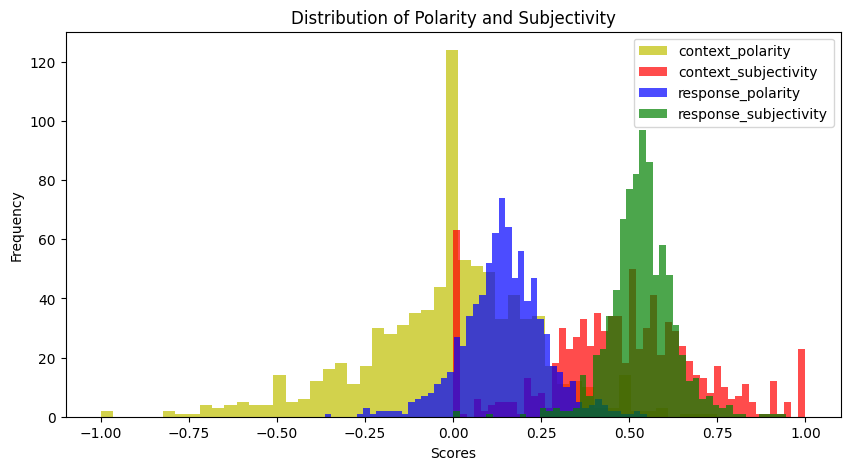

In [ ]:
visualise_textblob(
    textblob_results_df, "context_polarity", "context_subjectivity", "response_polarity", "response_subjectivity"
)

-   **Scores:** Values assigned to specific words or phrases based on their sentiment orientation (positive = 1, neutral = 0, negative = -1) in a predefined sentiment lexicon.
-   **Frequency:** The count of occurrences of specific sentiment-bearing words or phrases from a lexicon within a given text dataset.
-   **Distribution of Polarity:** A graphical or statistical representation that illustrates how often words associated with different sentiment polarities (positive, negative, neutral) are used across a corpus.
-   **Distribution of Subjectivity:** A measure of the frequency and pattern of words that convey subjectivity (personal feelings and opinions) as defined in a sentiment lexicon, within a text dataset.


### Machine Learning-Based Sentiment Analysis

#### (VADER - Valence Aware Dictionary and sEntiment Reasoner)


**Methodology:**
VADER is specifically tuned to sentiments expressed in social media and works well on texts from other domains too. It is a rule-based model for sentiment analysis that combines a lexicon approach with grammatical rules and conventions (like punctuation emphasis, capitalization, and degree modifiers) to quantify sentiment.

-   **Lexicon and Rules**: VADER uses a finely-tuned sentiment lexicon that contains about 7,500 word features weighted according to their sentiment bearing. It includes emojis, emoticons, and slangs.
-   **Sentiment Calculation**: It incorporates text normalization and assesses the intensity of the sentiment. Special rules are applied to account for capitalization, exclamation points, and modifiers that alter sentiment intensity.
-   **Compound Score**: The algorithm outputs normalized, weighted composite scores that provide metrics on the sentiment's positivity, negativity, and neutrality, as well as a compound score which aggregates these.

**Key Features of VADER:**

-   **Social Media Expressions:** Effectively handles emoticons, acronyms, and slang common in social media texts.
-   **Modifiers and Intensifiers:** Recognises and adjusts sentiments based on the presence of modifiers, such as in the phrase "not good".
-   **Nuanced Scoring:** Provides separate scores for positive, neutral, and negative sentiments, offering a detailed sentiment analysis.

VADER outputs a compound score that summarizes the overall sentiment of a text, indicating whether the content is positive, negative, or neutral. This makes VADER highly useful for applications requiring rapid and automated sentiment analysis, such as social media monitoring.

**Pros and Cons:**

-   _Pros_: Effective in handling informal text, quick and easy to use, interpretable scores.
-   _Cons_: Rule-based, so it may not adapt well to new expressions or contexts not covered by the predefined rules.


Downloading the VADER Lexicon


In [ ]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kmedr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Initializing the Sentiment Intensity Analyzer


In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
vader_results = analyze_vader(aggregated_df1, columns)
vader_results.head()

context  \
0  A few nights ago I talked to this girl I know ...   
1  A few years ago I was making love to my wife w...   
2  A friend of mine taking psychology advised I g...   
3  A girl and I were madly in love. We dated for ...   
4  A lot of times, I avoid situations where I am ...   

                                            response  \
0  Hey It takes a lot of courage to share your fe...   
1  First step always is to do a medical rule out ...   
2  I admire your courage for stating your view ab...   
3  Hi Boise, I am sorry that you have lost this l...   
4  Hello, and thank you for your question. First,...   

                                      context_scores  \
0  {'neg': 0.058, 'neu': 0.827, 'pos': 0.115, 'co...   
1  {'neg': 0.156, 'neu': 0.745, 'pos': 0.098, 'co...   
2  {'neg': 0.103, 'neu': 0.791, 'pos': 0.106, 'co...   
3  {'neg': 0.158, 'neu': 0.737, 'pos': 0.105, 'co...   
4  {'neg': 0.246, 'neu': 0.628, 'pos': 0.126, 'co...   

                                     response_scores  
0  {'neg': 0.016, 'neu': 0.73, 'pos': 0.254, 'com...  
1  {'neg': 0.123, 'neu': 0.764, 'pos': 0.112, 'co...  
2  {'neg': 0.081, 'neu': 0.757, 'pos': 0.162, 'co...  
3  {'neg': 0.127, 'neu': 0.687, 'pos': 0.186, 'co...  
4  {'neg': 0.207, 'neu': 0.622, 'pos': 0.171, 'co...

Lets plot the results.

**Context Sentiment Analysis**


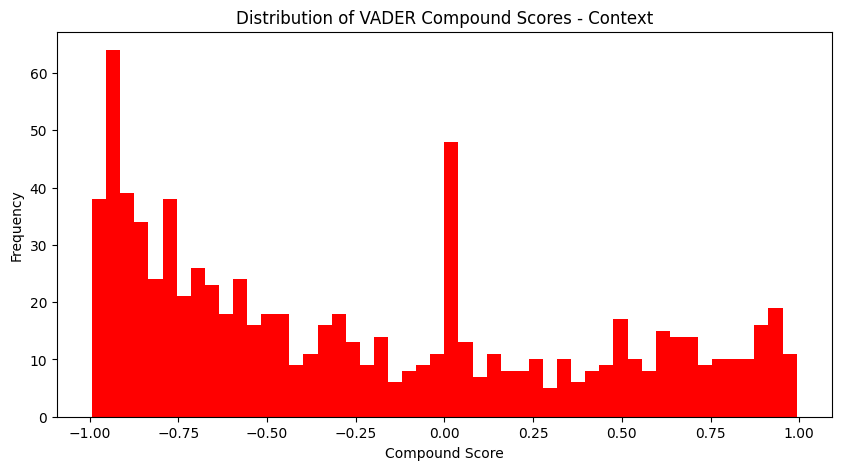

In [ ]:
visualise_vader(vader_results, "context_scores", "red")

**Response Sentiment Analysis**


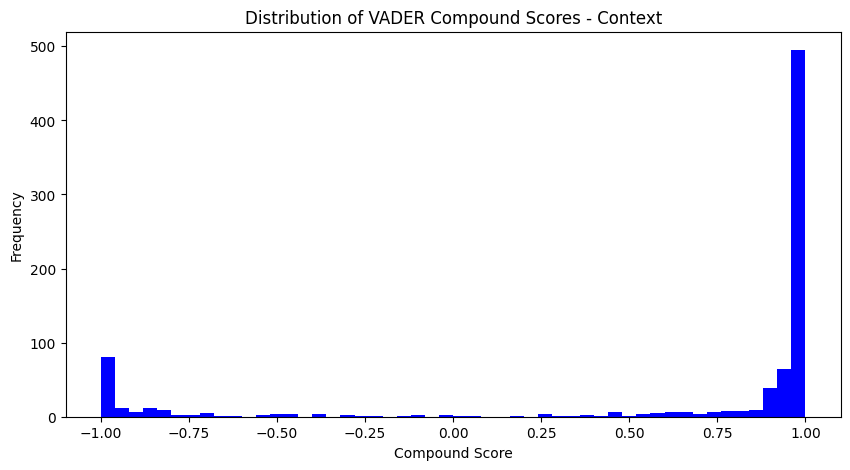

In [ ]:
visualise_vader(vader_results, "response_scores", "blue")

Lets overlay them for a better view.


In [ ]:
def visualise_vader(df, column, color, column2, color2):
    plt.figure(figsize=(10, 5))
    plt.hist(df[column].apply(lambda x: x["compound"]), bins=30, color=color, alpha=0.6)
    plt.hist(df[column2].apply(lambda x: x["compound"]), bins=30, color=color2, alpha=0.6)
    plt.xlabel("Compound Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of VADER Compound Scores - Overlay")
    plt.show()

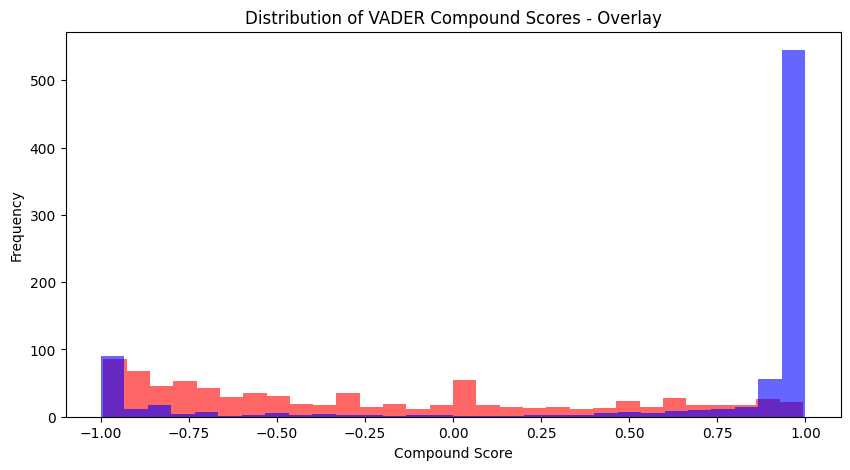

In [ ]:
visualise_vader(vader_results, "context_scores", "red", "response_scores", "blue")

-   **Compound Score:** A normalized score generated by VADER that combines the positive, neutral, and negative sentiment scores of text into a single metric ranging from -1 (most negative) to +1 (most positive).
-   **Frequency:** The count of sentiment-laden words identified by VADER within a text, reflecting how often positive, negative, or neutral sentiments appear.


### Deep Learning-Based Analysis Using Hugging Face Transformers

#### Model Used "Twitter-roBERTa-base for Sentiment Analysis - UPDATED (2022)"

Model details can be found here: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest


Deep learning-based sentiment analysis leverages advanced machine learning models, such as those provided by Hugging Face Transformers, to interpret and evaluate the sentiments expressed in textual data. This approach is particularly powerful due to its ability to understand complex patterns in language that simpler methods might miss.

**Methodology:**

Transformers are based on an architecture that leverages attention mechanisms. The model you mentioned, "Twitter-roBERTa-base", is a variant of BERT (Bidirectional Encoder Representations from Transformers) optimized for Twitter sentiment analysis.

-   **Architecture**: RoBERTa operates on the same principles as BERT but includes training optimizations. It processes words in context to the left and the right within a text, making it deeply bidirectional.
-   **Training**: The model is pretrained on a large corpus and then fine-tuned on a specific task like sentiment analysis using labeled data from Twitter.
-   **Application**: When analyzing text, the entire text sequence is processed, and the model leverages its learned features to predict sentiment.

**Overview of the Model:**

The "Twitter-roBERTa-base for Sentiment Analysis - UPDATED (2022)" is a model based on the RoBERTa architecture, a variant of BERT (Bidirectional Encoder Representations from Transformers) optimized by Facebook AI. It is pre-trained on a diverse dataset to capture a wide array of linguistic nuances and slang.

**Key Features:**

-   **Broad Language Understanding:** Originally designed for Twitter data, the model's capabilities extend to various text sources, making it versatile for different types of textual analysis.
-   **Updated Model:** The 2022 update means it incorporates recent language trends and usage patterns, enhancing its relevance and accuracy.
-   **Robust Contextual Understanding:** RoBERTa's architecture allows for a deeper and more nuanced understanding of context, which is crucial for sentiment analysis.

**Applications:**

This model excels at tasks like sentiment analysis across different platforms and mediums, not just limited to Twitter. It can be effectively used for analyzing customer feedback, market research, and other forms of textual data where understanding sentiment is crucial. Its ability to discern subtle nuances in sentiment makes it a valuable tool for businesses and researchers who need to keep a pulse on public sentiment as expressed through varied communication channels.

**Pros and Cons:**

-   _Pros_: Highly accurate, context-aware, can understand nuances and complexities of language better.
-   _Cons_: Requires significant computational resources, can be slow in inference without optimized hardware, requires large amounts of training data for fine-tuning.


Setting up the GPU for the model.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())

Using device: cuda:0
True


In [ ]:
print(torch.version.cuda)

12.4


In [ ]:
x = torch.randn(1).cuda()
print(x)

tensor([0.8861], device='cuda:0')


In [ ]:
import cupy as cp

x = cp.array([1, 2, 3])
print(x)
print(cp.linalg.norm(x))

[1 2 3]
3.7416573867739413


In [ ]:
print(cp.__version__)  # Check if CuPy is accessible and print its version
import spacy

spacy.prefer_gpu(0)

12.3.0


True

#### Setting Up a Sentiment Analysis Pipeline with RoBERTa and Transformers


In [ ]:
from transformers import AutoTokenizer, pipeline

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis", model=model_name, device=0)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### spaCy for Sentence Tokenization

Using SpaCy for sentance tokenization and Hugging Face Transformers for sentiment analysis.

I am going to exclude the `ner` and `parser` models from the `spaCy` pipeline to make it faster. Due to this I need to add the `sentencizer` to the pipeline.


In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
if not nlp.has_pipe("sentencizer"):
    nlp.add_pipe("sentencizer")

spaCy has `Visualizers` that can be used to visualise the output of the models. Lets use the `displacy` `visualizer` to visualise the output.


In [ ]:
nlp2 = spacy.load("en_core_web_sm")

In [ ]:
aggregated_df1_copy = aggregated_df1.copy()
aggregated_df1_copy["doc"] = aggregated_df1_copy["context"].apply(nlp2)
aggregated_df1_copy.head()

context  \
0  A few nights ago I talked to this girl I know ...   
1  A few years ago I was making love to my wife w...   
2  A friend of mine taking psychology advised I g...   
3  A girl and I were madly in love. We dated for ...   
4  A lot of times, I avoid situations where I am ...   

                                            response  \
0  Hey It takes a lot of courage to share your fe...   
1  First step always is to do a medical rule out ...   
2  I admire your courage for stating your view ab...   
3  Hi Boise, I am sorry that you have lost this l...   
4  Hello, and thank you for your question. First,...   

                                                 doc  
0  (A, few, nights, ago, I, talked, to, this, gir...  
1  (A, few, years, ago, I, was, making, love, to,...  
2  (A, friend, of, mine, taking, psychology, advi...  
3  (A, girl, and, I, were, madly, in, love, ., We...  
4  (A, lot, of, times, ,, I, avoid, situations, w...

In [ ]:
from spacy import displacy

options = {"bg": "#09a3d5", "color": "white"}
displacy.render(aggregated_df1_copy["doc"][0], style="dep", options=options)

In [ ]:
displacy.render(aggregated_df1_copy["doc"][0], style="ent")

I digress, lets get back to the sentiment analysis.

#### Lets first analyse the sentiment sentance by sentance.


In [ ]:
columns = ["context", "response"]

transformer_results_sentances = analyze_transformers_sentances(aggregated_df1, columns)
transformer_results_sentances.head()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


context  \
0  A few nights ago I talked to this girl I know ...   
1  A few years ago I was making love to my wife w...   
2  A friend of mine taking psychology advised I g...   
3  A girl and I were madly in love. We dated for ...   
4  A lot of times, I avoid situations where I am ...   

                                            response  \
0  Hey It takes a lot of courage to share your fe...   
1  First step always is to do a medical rule out ...   
2  I admire your courage for stating your view ab...   
3  Hi Boise, I am sorry that you have lost this l...   
4  Hello, and thank you for your question. First,...   

                                   context_sentiment  \
0  [{'sentiment': 'neutral', 'score': 0.775894701...   
1  [{'sentiment': 'negative', 'score': 0.76887869...   
2  [{'sentiment': 'neutral', 'score': 0.666209340...   
3  [{'sentiment': 'positive', 'score': 0.90781271...   
4  [{'sentiment': 'negative', 'score': 0.62042057...   

                                  response_sentiment  
0  [{'sentiment': 'positive', 'score': 0.82176440...  
1  [{'sentiment': 'neutral', 'score': 0.704388856...  
2  [{'sentiment': 'positive', 'score': 0.83010864...  
3  [{'sentiment': 'negative', 'score': 0.86444163...  
4  [{'sentiment': 'positive', 'score': 0.79868441...

Lets take a look at the a sample of the data.


In [ ]:
transformer_results_sentances.iloc[0]["context"]

'A few nights ago I talked to this girl I know about my self esteem issues for the first time. We talked for hours and she told me time and again that I was a great guy. She told me I was attractive, and have a great personality, etc. I really started to feel better about myself by the time I woke up the next morning. Now, though, I cannot stop thinking about her, but I leave to go back to college in a few days and I go to school 4 hours away from her. So now I feel constantly depressed because even if I told her how I felt it would not matter. I feel helpless and I do not know what to do.'

We get a list of dictionarys with the sentiment scores for each sentance.


In [ ]:
transformer_results_sentances.iloc[0]["context_sentiment"]

[{'sentiment': 'neutral', 'score': 0.7758947014808655},
 {'sentiment': 'positive', 'score': 0.9725618958473206},
 {'sentiment': 'positive', 'score': 0.9461064338684082},
 {'sentiment': 'positive', 'score': 0.9208849668502808},
 {'sentiment': 'neutral', 'score': 0.5386926531791687},
 {'sentiment': 'negative', 'score': 0.9261823892593384},
 {'sentiment': 'negative', 'score': 0.9210212230682373}]

#### Sentiment Analysis on the complete text Using Hugging Face Pipeline

Using Hugging Face AutoTokenizer for text tokenization into max length of 462 with a 50 overlap.


In [ ]:
columns = ["context", "response"]

transformer_results = analyze_transformers(aggregated_df1, columns)
transformer_results.head()

context  \
0  A few nights ago I talked to this girl I know ...   
1  A few years ago I was making love to my wife w...   
2  A friend of mine taking psychology advised I g...   
3  A girl and I were madly in love. We dated for ...   
4  A lot of times, I avoid situations where I am ...   

                                            response  \
0  Hey It takes a lot of courage to share your fe...   
1  First step always is to do a medical rule out ...   
2  I admire your courage for stating your view ab...   
3  Hi Boise, I am sorry that you have lost this l...   
4  Hello, and thank you for your question. First,...   

                                   context_sentiment  \
0  [[{'label': 'positive', 'score': 0.84718269109...   
1  [[{'label': 'negative', 'score': 0.87211817502...   
2  [[{'label': 'negative', 'score': 0.83888435363...   
3  [[{'label': 'positive', 'score': 0.62052839994...   
4  [[{'label': 'negative', 'score': 0.72281396389...   

                                  response_sentiment  
0  [[{'label': 'positive', 'score': 0.67954111099...  
1  [[{'label': 'neutral', 'score': 0.668563902378...  
2  [[{'label': 'positive', 'score': 0.49051114916...  
3  [[{'label': 'negative', 'score': 0.59924840927...  
4  [[{'label': 'neutral', 'score': 0.572084784507...

Lets take a look at a sample of the data.


In [ ]:
transformer_results.iloc[0]["context"]

'A few nights ago I talked to this girl I know about my self esteem issues for the first time. We talked for hours and she told me time and again that I was a great guy. She told me I was attractive, and have a great personality, etc. I really started to feel better about myself by the time I woke up the next morning. Now, though, I cannot stop thinking about her, but I leave to go back to college in a few days and I go to school 4 hours away from her. So now I feel constantly depressed because even if I told her how I felt it would not matter. I feel helpless and I do not know what to do.'

We get a single dictionary with a sentiment score for the complete text.


In [ ]:
transformer_results.iloc[0]["context_sentiment"]

[[{'label': 'positive', 'score': 0.8471826910972595}]]

In order to visulise the sentanced results, I will need to aggregate and summarise the results.


In [ ]:
def aggregate_sentiments(sentiment_list):
    """Aggregates sentiment counts from potentially nested lists of dictionaries."""
    sentiment_count = {"positive": 0, "neutral": 0, "negative": 0}

    def process_item(item):
        """Helper function to process each item which could be a list or a dictionary."""
        if isinstance(item, dict):
            sentiment = item.get("sentiment", item.get("label")).lower()  # accommodate both keys
            sentiment_count[sentiment] += 1
        elif isinstance(item, list):
            for sub_item in item:
                process_item(sub_item)  # Recursively process each sub-item

    for item in sentiment_list:
        process_item(item)  # Process each item in the initial list

    return sentiment_count


def summarize_sentiments(df, sentiment_columns):
    # Initialize a dictionary to hold sentiment totals for each column
    column_summaries = {}

    for col in sentiment_columns:
        # Apply aggregate_sentiments and sum across all entries in the DataFrame for each column
        df[f"{col}_aggregated"] = df[col].apply(aggregate_sentiments)
        column_totals = df[f"{col}_aggregated"].apply(pd.Series).sum()
        column_summaries[col] = {
            "positive": column_totals["positive"],
            "neutral": column_totals["neutral"],
            "negative": column_totals["negative"],
        }

    # Convert the dictionary to a DataFrame for a cleaner presentation
    summary_df = pd.DataFrame(column_summaries).T  # Transpose to have columns as headers
    summary_df.columns = ["positive", "neutral", "negative"]
    return summary_df


def plot_sentiment_distribution(df, title, is_percentage=False):
    if is_percentage:
        df_perc = df.div(df.sum(axis=1), axis=0) * 100
        fig, ax = plt.subplots(figsize=(10, 6))
        df_perc.plot(kind="bar", ax=ax, color=["green", "blue", "red"])
        for p in ax.patches:
            label = f"{p.get_height():.0f}%"
            ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height() + 0.75), ha="center")
    else:
        fig, ax = plt.subplots(figsize=(10, 6))
        df.plot(kind="bar", ax=ax, color=["green", "blue", "red"])
        for p in ax.patches:
            label = f"{p.get_height():.0f}"
            ax.annotate(label, (p.get_x() + p.get_width() / 2, p.get_height() * 1.020), ha="center")

    plt.title("Overall Sentiment Distribution - {}".format(title))
    plt.xlabel("Sentiment")
    plt.ylabel("Frequency")
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
sentiment_summary_sentances = summarize_sentiments(
    transformer_results_sentances, ["context_sentiment", "response_sentiment"]
)
sentiment_summary_sentances

positive  neutral  negative
context_sentiment        318     1287      2430
response_sentiment      6195    17830      7768

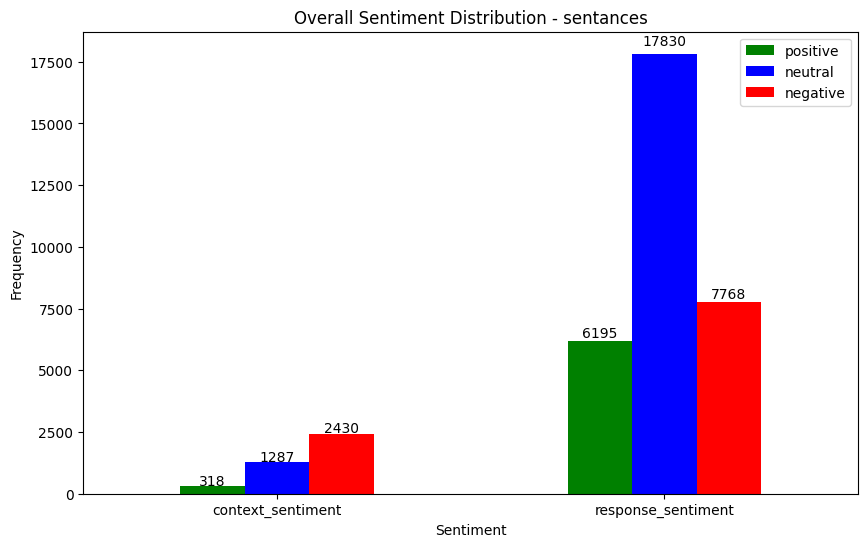

In [ ]:
plot_sentiment_distribution(sentiment_summary_sentances, "sentances")

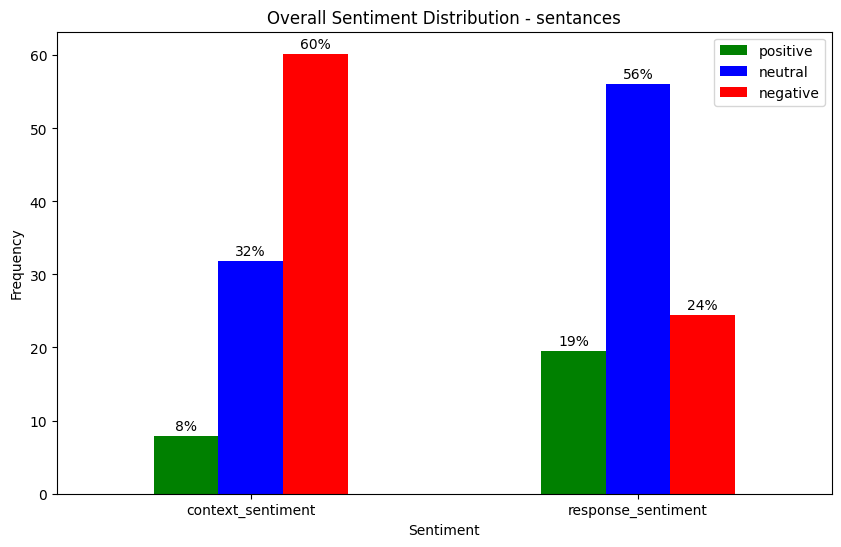

In [ ]:
plot_sentiment_distribution(sentiment_summary_sentances, "sentances", is_percentage=True)

Lets plot the full text results.


In [ ]:
sentiment_summary = summarize_sentiments(transformer_results, ["context_sentiment", "response_sentiment"])
sentiment_summary

positive  neutral  negative
context_sentiment         46      107       683
response_sentiment       263     1549       354

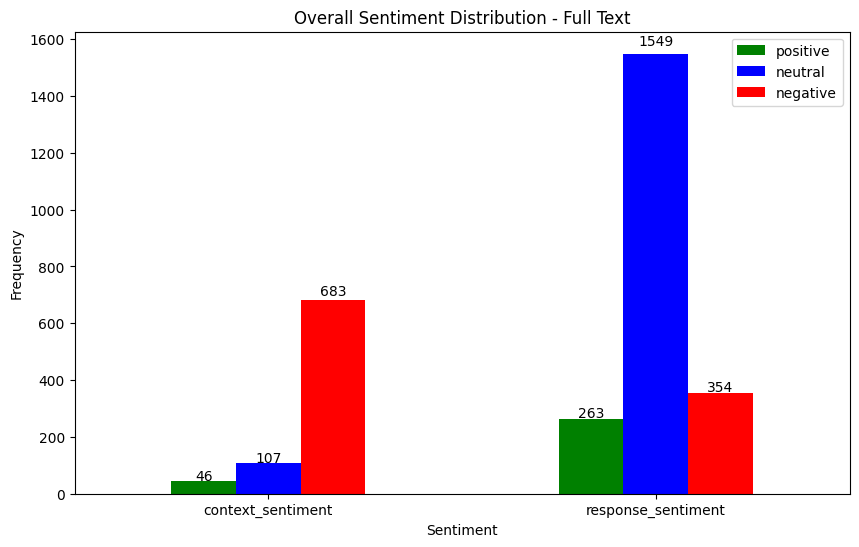

In [ ]:
plot_sentiment_distribution(sentiment_summary, "Full Text")

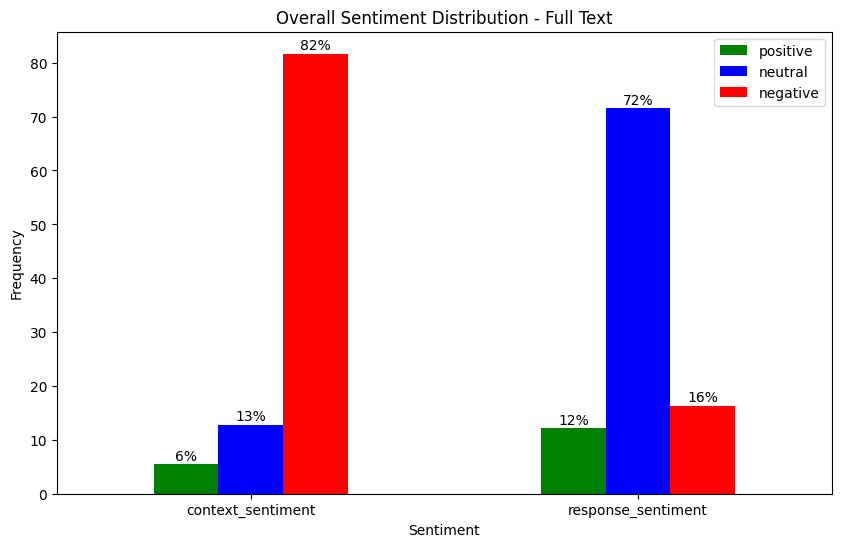

In [ ]:
plot_sentiment_distribution(sentiment_summary, "Full Text", is_percentage=True)

![bar_plot](../images/mhcc_results.png)

When we see the plots side by side we see a 21% increase in negative sentiment in the Context column when done on the whole text, and a 7% decline in negative sentiment in the Response column.

A possible answer for this could be the repeating back of some of the Context in the Response, thus making sentances with negative words or phrases appear as negative sentiment in the Response column.


The Vader and Hugging Face approaches show a similar trend in the analysis, however the Hugging Face approach is more accurate.

I will use the Hugging Face approach for the sentiment analysis.

For the purpose of this analysis, I will use the sentiment scores from the whole text analysis.


### The Data Sets - Cont.


#### Alexander_Street-shareGPT_2.0 (Psych8k) Data Analysis


In [ ]:
df2 = read_data_df("../assets/json/Alexander_Street_shareGPT_2.0.json")
df2.head()

instruction  \
0  If you are a counsellor, please answer the que...   
1  If you are a counsellor, please answer the que...   
2  If you are a counsellor, please answer the que...   
3  If you are a counsellor, please answer the que...   
4  If you are a counsellor, please answer the que...   

                                               input  \
0  Lately, I have been feeling really disconnecte...   
1  Lately, I have been feeling really stressed an...   
2  Lately, I have been feeling a bit off. I somet...   
3  Lately, I have been feeling a bit off. I have ...   
4  Lately, I have been feeling quite off. I have ...   

                                              output  
0  Thank you for sharing your experience with me....  
1  Thank you for sharing your experience with me....  
2  I appreciate you sharing your concerns with me...  
3  Thank you for sharing your feelings and experi...  
4  I appreciate you sharing your experiences with...

In [ ]:
df2.describe()

instruction  \
count                                                8187   
unique                                                  1   
top     If you are a counsellor, please answer the que...   
freq                                                 8187   

                                                    input  \
count                                                8187   
unique                                               8187   
top     Lately, I have been feeling really disconnecte...   
freq                                                    1   

                                                   output  
count                                                8187  
unique                                               8187  
top     Thank you for sharing your experience with me....  
freq                                                    1

In [ ]:
columns = ["input", "output"]

transformer_results_2 = analyze_transformers(df2, columns)
transformer_results_2.head()

instruction  \
0  If you are a counsellor, please answer the que...   
1  If you are a counsellor, please answer the que...   
2  If you are a counsellor, please answer the que...   
3  If you are a counsellor, please answer the que...   
4  If you are a counsellor, please answer the que...   

                                               input  \
0  Lately, I have been feeling really disconnecte...   
1  Lately, I have been feeling really stressed an...   
2  Lately, I have been feeling a bit off. I somet...   
3  Lately, I have been feeling a bit off. I have ...   
4  Lately, I have been feeling quite off. I have ...   

                                              output  \
0  Thank you for sharing your experience with me....   
1  Thank you for sharing your experience with me....   
2  I appreciate you sharing your concerns with me...   
3  Thank you for sharing your feelings and experi...   
4  I appreciate you sharing your experiences with...   

                                     input_sentiment  \
0  [[{'label': 'negative', 'score': 0.75407278537...   
1  [[{'label': 'negative', 'score': 0.78466022014...   
2  [[{'label': 'neutral', 'score': 0.514491796493...   
3  [[{'label': 'negative', 'score': 0.80572962760...   
4  [[{'label': 'negative', 'score': 0.83298754692...   

                                    output_sentiment  
0  [[{'label': 'neutral', 'score': 0.706706166267...  
1  [[{'label': 'neutral', 'score': 0.587901294231...  
2  [[{'label': 'neutral', 'score': 0.497891664505...  
3  [[{'label': 'neutral', 'score': 0.663677930831...  
4  [[{'label': 'positive', 'score': 0.59993469715...

In [ ]:
sentiment_summary_2 = summarize_sentiments(transformer_results_2, ["input_sentiment", "output_sentiment"])
sentiment_summary_2

positive  neutral  negative
input_sentiment       1385     2013      4789
output_sentiment      3182     3969      1036

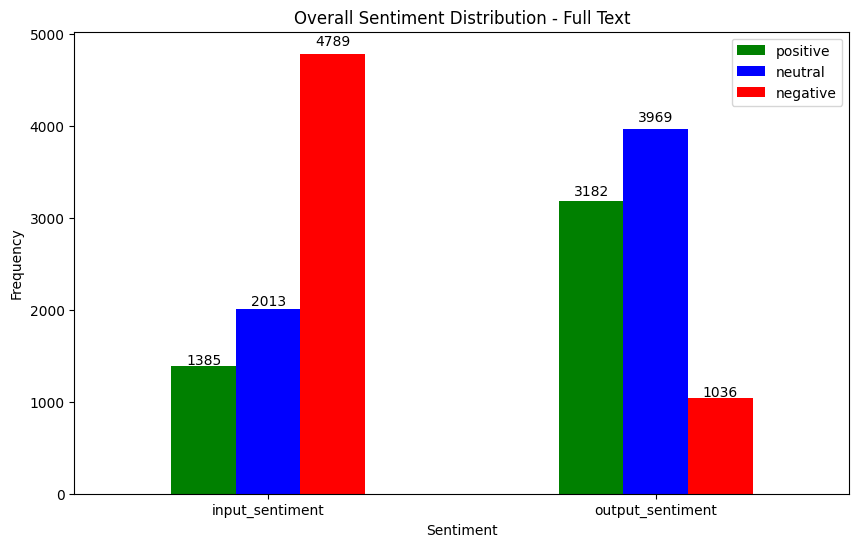

In [ ]:
plot_sentiment_distribution(sentiment_summary_2, "Full Text")

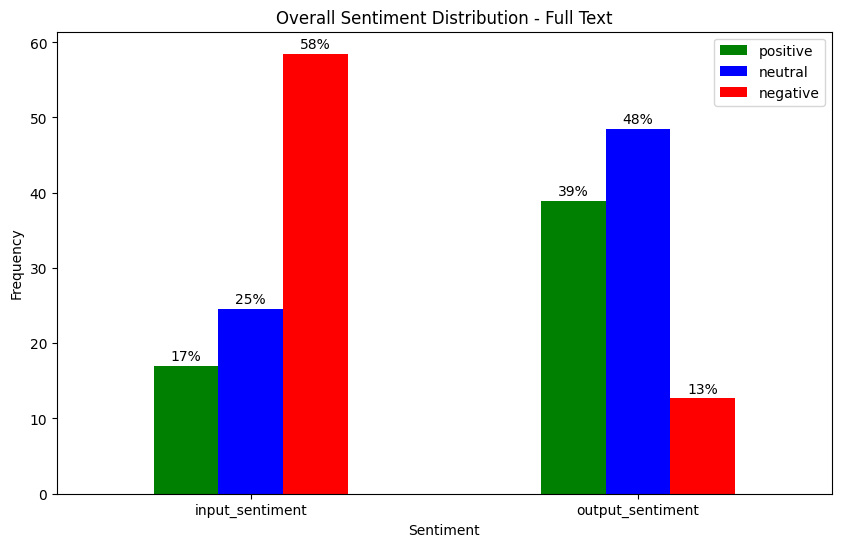

In [ ]:
plot_sentiment_distribution(sentiment_summary_2, "Full Text", is_percentage=True)

### Patterns and Responses Data


In [ ]:
text3 = json.load(open("../assets/json/intents.json"))
df3 = pd.json_normalize(text3, record_path="intents")
df3["patterns"] = df3["patterns"].apply(lambda x: ", ".join(x))
df3["responses"] = df3["responses"].apply(lambda x: ", ".join(x))
df3.head()

tag                                           patterns  \
0   greeting  Hi, Hey, Is anyone there?, Hi there, Hello, He...   
1    morning                                       Good morning   
2  afternoon                                     Good afternoon   
3    evening                                       Good evening   
4      night                                         Good night   

                                           responses  
0  Hello there. Tell me how are you feeling today...  
1  Good morning. I hope you had a good night's sl...  
2             Good afternoon. How is your day going?  
3               Good evening. How has your day been?  
4  Good night. Get some proper sleep, Good night....

In [ ]:
df3_exploded = df3.explode("patterns").explode("responses")
df3_exploded.head()

tag                                           patterns  \
0   greeting  Hi, Hey, Is anyone there?, Hi there, Hello, He...   
1    morning                                       Good morning   
2  afternoon                                     Good afternoon   
3    evening                                       Good evening   
4      night                                         Good night   

                                           responses  
0  Hello there. Tell me how are you feeling today...  
1  Good morning. I hope you had a good night's sl...  
2             Good afternoon. How is your day going?  
3               Good evening. How has your day been?  
4  Good night. Get some proper sleep, Good night....

In [ ]:
df3_exploded.describe()

tag                                           patterns  \
count         80                                                 80   
unique        80                                                 80   
top     greeting  Hi, Hey, Is anyone there?, Hi there, Hello, He...   
freq           1                                                  1   

                                                responses  
count                                                  80  
unique                                                 80  
top     Hello there. Tell me how are you feeling today...  
freq                                                    1

In [ ]:
df3_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tag        80 non-null     object
 1   patterns   80 non-null     object
 2   responses  80 non-null     object
dtypes: object(3)
memory usage: 2.5+ KB


In [ ]:
columns = ["patterns", "responses"]

transformer_results_3 = analyze_transformers(df3, columns)
transformer_results_3.head()

tag                                           patterns  \
0   greeting  Hi, Hey, Is anyone there?, Hi there, Hello, He...   
1    morning                                       Good morning   
2  afternoon                                     Good afternoon   
3    evening                                       Good evening   
4      night                                         Good night   

                                           responses  \
0  Hello there. Tell me how are you feeling today...   
1  Good morning. I hope you had a good night's sl...   
2             Good afternoon. How is your day going?   
3               Good evening. How has your day been?   
4  Good night. Get some proper sleep, Good night....   

                                  patterns_sentiment  \
0  [[{'label': 'positive', 'score': 0.63939869403...   
1  [[{'label': 'positive', 'score': 0.85136789083...   
2  [[{'label': 'positive', 'score': 0.86109834909...   
3  [[{'label': 'positive', 'score': 0.85331916809...   
4  [[{'label': 'positive', 'score': 0.80915707349...   

                                 responses_sentiment  
0  [[{'label': 'positive', 'score': 0.97537392377...  
1  [[{'label': 'positive', 'score': 0.96497344970...  
2  [[{'label': 'positive', 'score': 0.92226946353...  
3  [[{'label': 'positive', 'score': 0.91589701175...  
4  [[{'label': 'positive', 'score': 0.94349718093...

In [ ]:
transformer_results_3.describe()

tag                                           patterns  \
count         80                                                 80   
unique        80                                                 80   
top     greeting  Hi, Hey, Is anyone there?, Hi there, Hello, He...   
freq           1                                                  1   

                                                responses  \
count                                                  80   
unique                                                 80   
top     Hello there. Tell me how are you feeling today...   
freq                                                    1   

                                       patterns_sentiment  \
count                                                  80   
unique                                                 80   
top     [[{'label': 'positive', 'score': 0.63939869403...   
freq                                                    1   

                                      responses_sentiment  
count                                                  80  
unique                                                 80  
top     [[{'label': 'positive', 'score': 0.97537392377...  
freq                                                    1

In [ ]:
sentiment_summary_3 = summarize_sentiments(transformer_results_3, ["patterns_sentiment", "responses_sentiment"])
sentiment_summary_3

positive  neutral  negative
patterns_sentiment         16       39        25
responses_sentiment        26       31        23

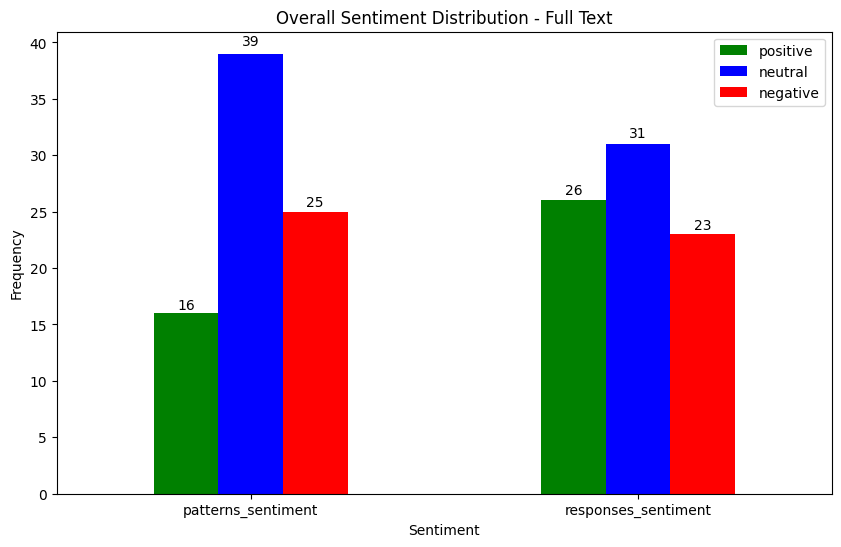

In [ ]:
plot_sentiment_distribution(sentiment_summary_3, "Full Text")

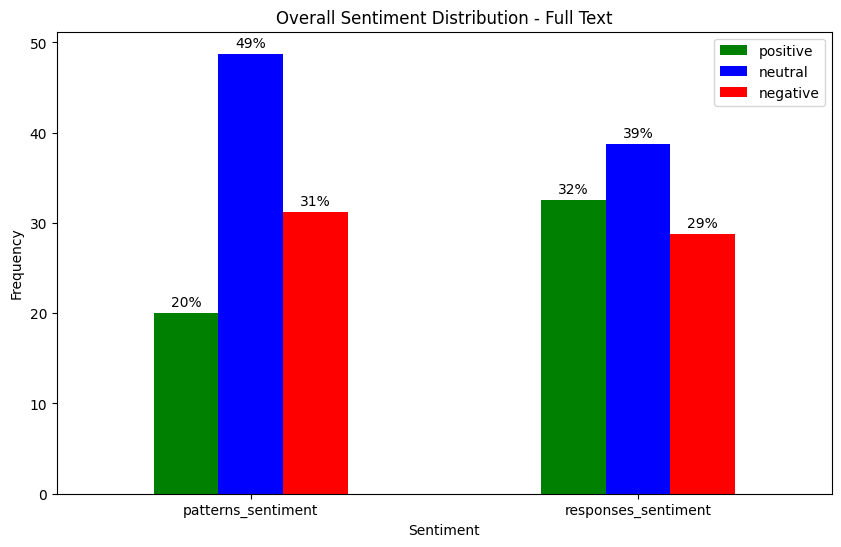

In [ ]:
plot_sentiment_distribution(sentiment_summary_3, "Full Text", is_percentage=True)

### CAMS Data Main


In [ ]:
file_path = "../assets/csv/added_CAMS_data.csv"

with open(file_path, "rb") as file:
    result = chardet.detect(file.read())
    enc_used = result["encoding"]

print(result, enc_used)

df4 = pd.read_csv(file_path, encoding=result["encoding"])

for column in df4.columns:
    if df4[column].dtype == object:  # Check if the column is of type object
        df4[column] = df4[column].str.strip().apply(clean_text)
df4.head()

{'encoding': 'MacRoman', 'confidence': 0.7084025687663215, 'language': ''} MacRoman


selftext  cause  \
0  It s been a good break so far, as school is th...      2   
1  I look like a drug addict. I lost so much weig...      3   
2  I bet you guys get this a lot but it s going t...      5   
3  I am just falling apart. I have no one and I j...      5   
4  I am literally useless. I cannot function. Hav...      5   

                                           inference  
0  school is the source of triggers ,no energy to...  
1                 look like a dug addict, anorexic ,  
2                    its my birth day, no one caress  
3                                        have no one  
4                     feeling useless, no confidence

In [ ]:
df4.describe(include="object")

selftext inference
count      3153      2878
unique     3152      2872
top      Title.    lonely
freq          2         3

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   selftext   3153 non-null   object
 1   cause      3155 non-null   int64 
 2   inference  2878 non-null   object
dtypes: int64(1), object(2)
memory usage: 74.1+ KB


In [ ]:
df4 = df4.dropna()
df4.describe(include="object")

selftext inference
count                                                2877      2877
unique                                               2877      2871
top     It s been a good break so far, as school is th...    lonely
freq                                                    1         3

In [ ]:
columns = ["selftext", "inference"]

transformer_results_4 = analyze_transformers(df4, columns)
transformer_results_4.head()

selftext  cause  \
0  It s been a good break so far, as school is th...      2   
1  I look like a drug addict. I lost so much weig...      3   
2  I bet you guys get this a lot but it s going t...      5   
3  I am just falling apart. I have no one and I j...      5   
4  I am literally useless. I cannot function. Hav...      5   

                                           inference  \
0  school is the source of triggers ,no energy to...   
1                 look like a dug addict, anorexic ,   
2                    its my birth day, no one caress   
3                                        have no one   
4                     feeling useless, no confidence   

                                  selftext_sentiment  \
0  [[{'label': 'negative', 'score': 0.72006231546...   
1  [[{'label': 'negative', 'score': 0.93822944164...   
2  [[{'label': 'neutral', 'score': 0.486718058586...   
3  [[{'label': 'negative', 'score': 0.92582124471...   
4  [[{'label': 'negative', 'score': 0.93940913677...   

                                 inference_sentiment  
0  [[{'label': 'negative', 'score': 0.91122418642...  
1  [[{'label': 'negative', 'score': 0.86623787879...  
2  [[{'label': 'positive', 'score': 0.65857613086...  
3  [[{'label': 'neutral', 'score': 0.546925008296...  
4  [[{'label': 'negative', 'score': 0.88795298337...

In [ ]:
sentiment_summary_4 = summarize_sentiments(transformer_results_4, ["selftext_sentiment", "inference_sentiment"])
sentiment_summary_4

positive  neutral  negative
selftext_sentiment        256      359      2840
inference_sentiment       102      353      2422

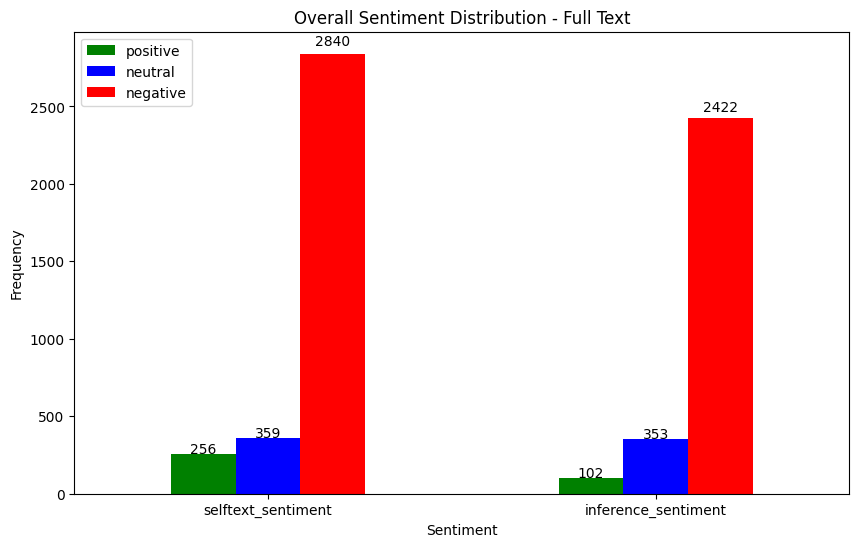

In [ ]:
plot_sentiment_distribution(sentiment_summary_4, "Full Text")

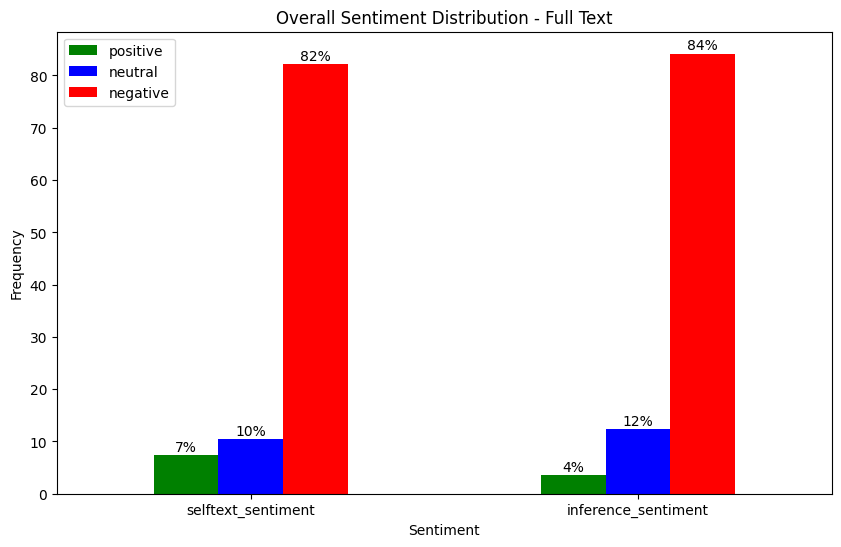

In [ ]:
plot_sentiment_distribution(sentiment_summary_4, "Full Text", is_percentage=True)

#### CAMS Training Data


In [ ]:
df5 = read_data_df("../assets/csv/IntentSDCNL_Training.csv")
df5.head()

selftext  annotations  \
0  Hi I do not really know how to phrase this sit...          5.0   
1  i have been so depressed these past couple wee...          1.0   
2  Hi..I do not know where else to go. I am devas...          5.0   
3  The shit like it will get better, everyone is ...          0.0   
4  I wish I was prettier. I wish I did not feel l...          1.0   

                                     interpretations  
0  have no ambition , feel worthless , unfair to ...  
1          ugly , fat , worthless , become miserable  
2  numb , out of control , nobody cares , do not ...  
3                                                     
4  wish i was prettier , feel like burden , more ...

In [ ]:
df5.describe(include="object")

selftext interpretations
count                                                1461            1461
unique                                               1453            1134
top     I am almost 40, on disability morbidly obese a...                
freq                                                    2             327

In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   selftext         1461 non-null   object 
 1   annotations      1458 non-null   float64
 2   interpretations  1461 non-null   object 
dtypes: float64(1), object(2)
memory usage: 34.4+ KB


In [ ]:
df5.dropna(inplace=True)
df5.describe(include="object")

selftext interpretations
count                                                1458            1458
unique                                               1450            1134
top     I am almost 40, on disability morbidly obese a...                
freq                                                    2             324

In [ ]:
columns = ["selftext", "interpretations"]

df5_tr = analyze_transformers(df5, columns)
df5_tr.head()

selftext  annotations  \
0  Hi I do not really know how to phrase this sit...          5.0   
1  i have been so depressed these past couple wee...          1.0   
2  Hi..I do not know where else to go. I am devas...          5.0   
3  The shit like it will get better, everyone is ...          0.0   
4  I wish I was prettier. I wish I did not feel l...          1.0   

                                     interpretations  \
0  have no ambition , feel worthless , unfair to ...   
1          ugly , fat , worthless , become miserable   
2  numb , out of control , nobody cares , do not ...   
3                                                      
4  wish i was prettier , feel like burden , more ...   

                                  selftext_sentiment  \
0  [[{'label': 'positive', 'score': 0.53923100233...   
1  [[{'label': 'negative', 'score': 0.94807636737...   
2  [[{'label': 'negative', 'score': 0.94292259216...   
3  [[{'label': 'negative', 'score': 0.71998685598...   
4  [[{'label': 'negative', 'score': 0.37773898243...   

                           interpretations_sentiment  
0  [[{'label': 'negative', 'score': 0.93295884132...  
1  [[{'label': 'negative', 'score': 0.92511022090...  
2  [[{'label': 'negative', 'score': 0.92401957511...  
3  [[{'label': 'positive', 'score': 0.40129864215...  
4  [[{'label': 'neutral', 'score': 0.402148038148...

In [ ]:
columns = ["selftext_sentiment", "interpretations_sentiment"]

df5_ss = summarize_sentiments(df5_tr, columns)
df5_ss

positive  neutral  negative
selftext_sentiment               97      134      1454
interpretations_sentiment       351       98      1009

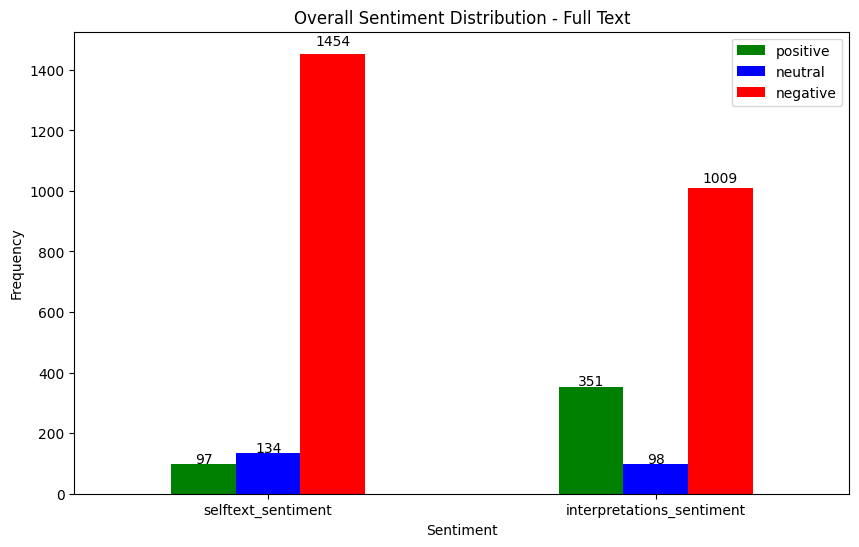

In [ ]:
plot_sentiment_distribution(df5_ss, "Full Text")

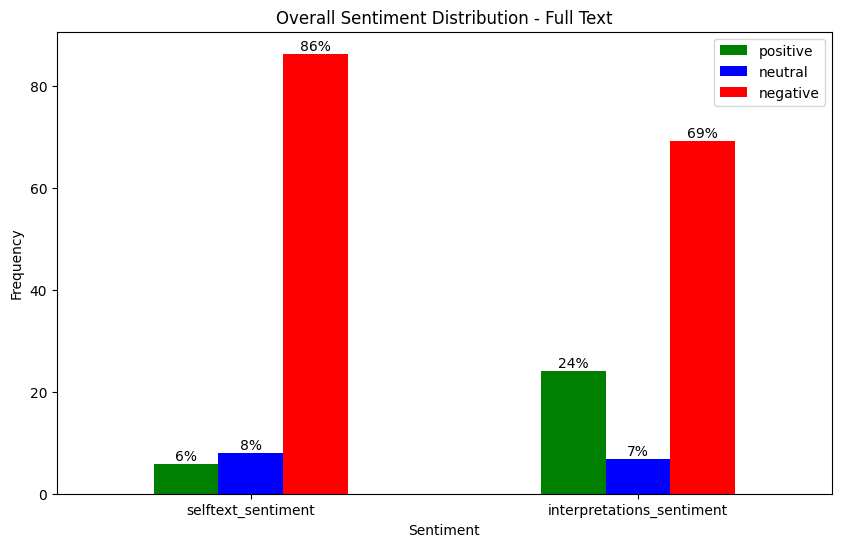

In [ ]:
plot_sentiment_distribution(df5_ss, "Full Text", is_percentage=True)

#### CAMS Testing Data


In [ ]:
df6 = read_data_df("../assets/csv/IntentSDCNL_Testing.csv")
df6.head()

selftext  annotations  \
0  Indubitably, I am not worth anything as a bein...            1   
1  Almost everyday I wake up hating myself, why w...            5   
2                        To kill myself if i am ugly            1   
3  God help me.... I know I should go to the hosp...            1   
4  I really do not want to do anything anymore. W...            2   

                                     interpretations  
0  not productive, worthless, hate, bored , issue...  
1  feeling trapped, paranoid, barely talks to me,...  
2                                               ugly  
3  abuse suffered, hard person to love, scars, cy...  
4  wasting money, sulking, failure, disappointmen...

In [ ]:
df6.describe(include="object")

selftext interpretations
count                                                 370             370
unique                                                370             342
top     Indubitably, I am not worth anything as a bein...                
freq                                                    1              29

In [ ]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   selftext         370 non-null    object
 1   annotations      370 non-null    int64 
 2   interpretations  370 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


In [ ]:
columns = ["selftext", "interpretations"]

df6_tr = analyze_transformers(df6, columns)
df6_tr.head()

selftext  annotations  \
0  Indubitably, I am not worth anything as a bein...            1   
1  Almost everyday I wake up hating myself, why w...            5   
2                        To kill myself if i am ugly            1   
3  God help me.... I know I should go to the hosp...            1   
4  I really do not want to do anything anymore. W...            2   

                                     interpretations  \
0  not productive, worthless, hate, bored , issue...   
1  feeling trapped, paranoid, barely talks to me,...   
2                                               ugly   
3  abuse suffered, hard person to love, scars, cy...   
4  wasting money, sulking, failure, disappointmen...   

                                  selftext_sentiment  \
0  [[{'label': 'negative', 'score': 0.92073392868...   
1  [[{'label': 'negative', 'score': 0.87529474496...   
2  [[{'label': 'negative', 'score': 0.89184421300...   
3  [[{'label': 'negative', 'score': 0.51534336805...   
4  [[{'label': 'negative', 'score': 0.94397825002...   

                           interpretations_sentiment  
0  [[{'label': 'negative', 'score': 0.90166431665...  
1  [[{'label': 'negative', 'score': 0.92114889621...  
2  [[{'label': 'negative', 'score': 0.68091732263...  
3  [[{'label': 'negative', 'score': 0.87702816724...  
4  [[{'label': 'negative', 'score': 0.93940937519...

In [ ]:
columns = ["selftext_sentiment", "interpretations_sentiment"]

df6_ss = summarize_sentiments(df6_tr, columns)
df6_ss

positive  neutral  negative
selftext_sentiment               22       36       349
interpretations_sentiment        42       46       282

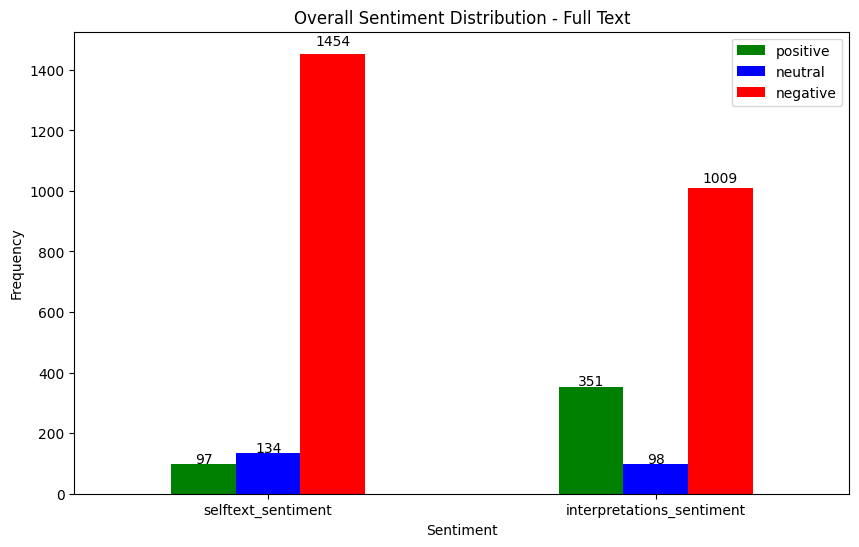

In [ ]:
plot_sentiment_distribution(df5_ss, "Full Text")

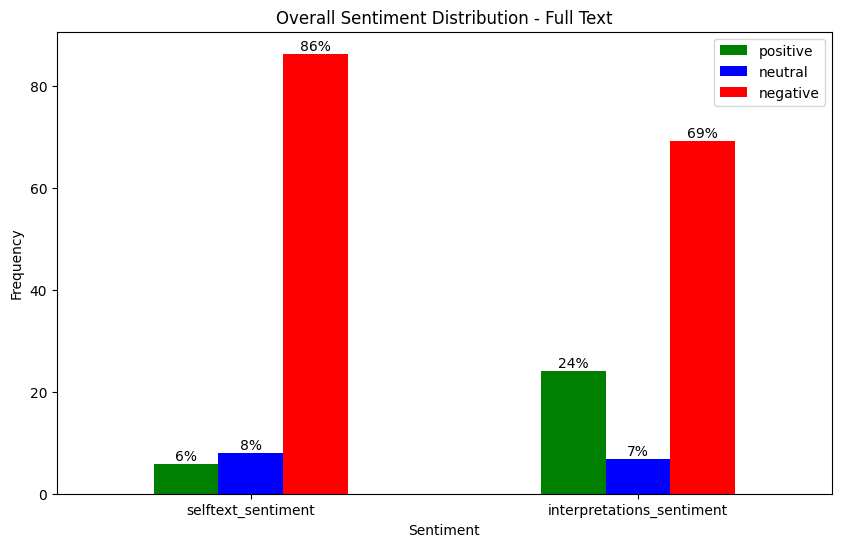

In [ ]:
plot_sentiment_distribution(df5_ss, "Full Text", is_percentage=True)

#### Reddit Data


In [ ]:
df7 = read_data_df("../assets/csv/Reddit_depression_dataset.csv")
df7.head()

text     label
0  He said he had not felt that way before, sugge...      mild
1  Hey there r assistance, Not sure if this is th...   minimum
2  My mom then hit me with the newspaper and it s...   minimum
3  until i met my new boyfriend, he is amazing, h...      mild
4  October is Domestic Violence Awareness Month a...  moderate

In [ ]:
df7.describe(include="object")

text    label
count                                                3553     3553
unique                                               3531        4
top     Hello, You are invited to complete a survey fo...  minimum
freq                                                    4     2587

In [ ]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3553 non-null   object
 1   label   3553 non-null   object
dtypes: object(2)
memory usage: 55.6+ KB


Lets drop the duplicates.


In [ ]:
df7 = df7.drop_duplicates(subset=["text"])
df7.describe(include="object")

text    label
count                                                3531     3531
unique                                               3531        4
top     He said he had not felt that way before, sugge...  minimum
freq                                                    1     2566

In [ ]:
unique_values = df7["label"].unique()
print(unique_values)

['mild' 'minimum' 'moderate' 'severe']


As this data is labeled we can do a basic comparison of the sentiment analysis.


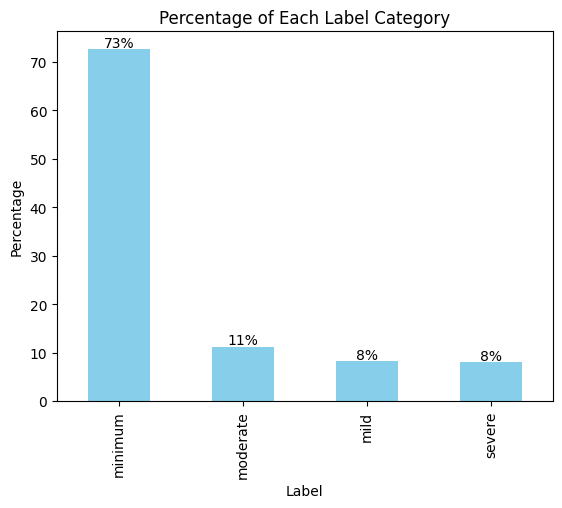

In [ ]:
label_counts = df7["label"].value_counts(normalize=True) * 100

label_counts.plot(kind="bar", color="skyblue")
plt.title("Percentage of Each Label Category")
plt.xlabel("Label")
plt.ylabel("Percentage")

# Adding the percentage labels on top of each bar
for index, value in enumerate(label_counts):
    plt.text(index, value + 0.5, f"{value:.0f}%", ha="center")

plt.show()

In [ ]:
columns = ["text"]

df7_tr = analyze_transformers(df7, columns)
df7_tr.head()

text     label  \
0  He said he had not felt that way before, sugge...      mild   
1  Hey there r assistance, Not sure if this is th...   minimum   
2  My mom then hit me with the newspaper and it s...   minimum   
3  until i met my new boyfriend, he is amazing, h...      mild   
4  October is Domestic Violence Awareness Month a...  moderate   

                                      text_sentiment  
0  [[{'label': 'negative', 'score': 0.67490017414...  
1  [[{'label': 'neutral', 'score': 0.760479927062...  
2  [[{'label': 'negative', 'score': 0.72564029693...  
3  [[{'label': 'positive', 'score': 0.53570091724...  
4  [[{'label': 'negative', 'score': 0.90911322832...

In [ ]:
columns = ["text_sentiment"]

df7_ss = summarize_sentiments(df7_tr, columns)
df7_ss

positive  neutral  negative
text_sentiment       448      844      2239

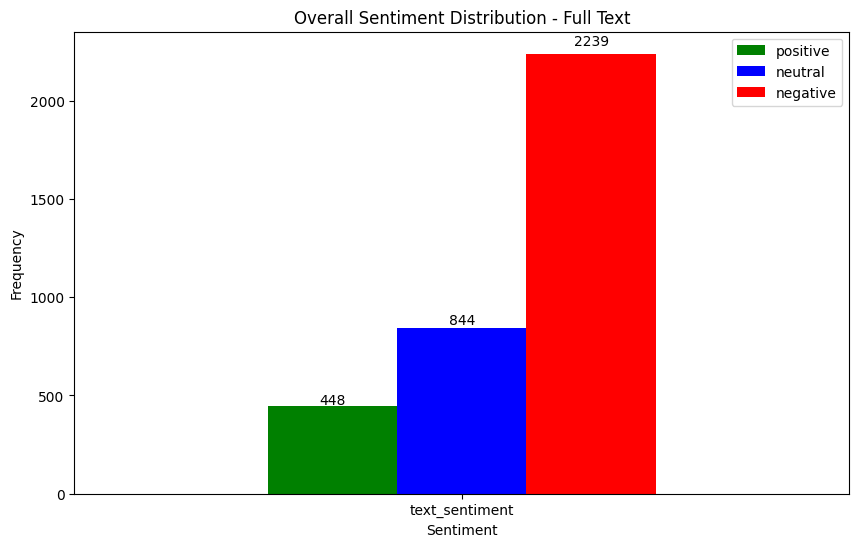

In [ ]:
plot_sentiment_distribution(df7_ss, "Full Text")

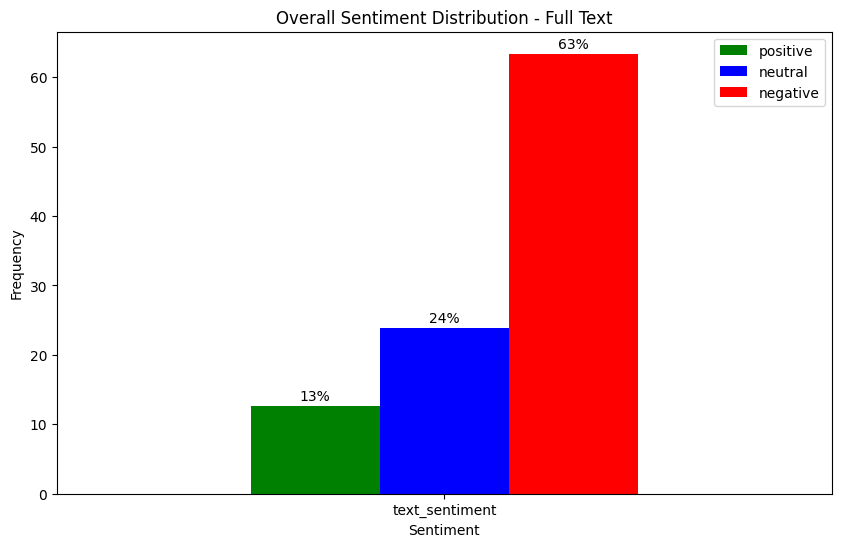

In [ ]:
plot_sentiment_distribution(df7_ss, "Full Text", is_percentage=True)

#### Survey Data


In [ ]:
df8 = read_data_df("../assets/csv/survey_responses_17-07-24.xlsx")
df8.head()

timestamp what_is_your_age? what_is_your_gender?  \
0 2024-07-11 10:53:48.107       17-23 years                 Male   
1 2024-07-11 11:31:56.356       17-23 years                 Male   
2 2024-07-11 11:33:50.212       17-23 years                 Male   
3 2024-07-11 11:38:33.353       17-23 years               Female   
4 2024-07-11 11:39:33.766       17-23 years                 Male   

  what_is_your_current_occupation? what_country_are_you_from?  \
0                          Student                      India   
1                          Student                      India   
2                          Student                      India   
3                          Student                      India   
4                          Student                      India   

  on_average,_how_many_hours_per_day_do_you_spend_on_digital_devices_(smartphones,_tablets,_computers,_etc.)?  \
0                                          4-6 hours                                                            
1                                          4-6 hours                                                            
2                                          4-6 hours                                                            
3                                          2-4 hours                                                            
4                                  More than 6 hours                                                            

  which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_all_of_my_time]  \
0                             Watching videos Movies                                                          
1                      Studying Educational purposes                                                          
2                             Watching videos Movies                                                          
3                      Studying Educational purposes                                                          
4                             Watching videos Movies                                                          

  which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_most_of_my_time]  \
0                                                                                                              
1                            Work Professional tasks                                                           
2                            Work Professional tasks                                                           
3                            Work Professional tasks                                                           
4  Social media (Facebook, TikTok, X formally Twi...                                                           

  which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_some_of_my_time]  \
0                                                                                                              
1                             Watching videos Movies                                                           
2                      Studying Educational purposes                                                           
3  Social media (Facebook, TikTok, X formally Twi...                                                           
4                      Studying Educational purposes                                                           

  which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_hardly_any_time]  \
0                                                                                                              
1  Social media (Facebook, TikTok, X formally Twi...                                                           
2  Social media (Facebook, TikTok, X formally Twi...                                                           
3                                             Gaming                        

In [ ]:
df8.columns.to_list()

['timestamp',
 'what_is_your_age?',
 'what_is_your_gender?',
 'what_is_your_current_occupation?',
 'what_country_are_you_from?',
 'on_average,_how_many_hours_per_day_do_you_spend_on_digital_devices_(smartphones,_tablets,_computers,_etc.)?',
 'which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_all_of_my_time]',
 'which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_most_of_my_time]',
 'which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_some_of_my_time]',
 'which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_hardly_any_time]',
 'which_activities_do_you_spend_your_time_on_digital_devices?_(_select_in_order_of_usage)_[_almost_no_time_or_no_time]',
 'do_you_use_digital_devices_at_night_before_sleep?',
 'do_you_think_the_time_you_spend_on_your_digital_devices_is_good_use_of_your_time?',
 'how_often_do_you_feel_stressed?',
 'have_you_ever_fel

In [ ]:
df8.columns = [
    "timestamp",
    "age",
    "gender",
    "occupation",
    "country",
    "how_many_hours_per_day",
    "activities_all_of_my_time",
    "activities_most_of_my_time",
    "activities_some_of_my_time",
    "activities_hardly_any_time",
    "activities_almost_no_time_or_no_time",
    "use_before_sleep",
    "good_use_of_time",
    "feel_stressed",
    "depression",
    "comfortable_discussing_with_friends_or_family",
    "affects_mental_health",
    "physical_activities",
    "sleep_quality",
    "nutrition_and_diet",
    "aware_of_the_mental_health_resources",
    "sought_professional_help_for_mental_health",
    "support_most_preferred",
    "support_somewhat_preferred",
    "support_preferred",
    "support_somewhat_not_preferred",
    "support_least_preferred",
    "using_ai_powered_chatbot",
    "features",
    "suggestions",
]
df8.head(1)

timestamp          age gender occupation country  \
0 2024-07-11 10:53:48.107  17-23 years   Male    Student   India   

  how_many_hours_per_day activities_all_of_my_time activities_most_of_my_time  \
0              4-6 hours    Watching videos Movies                              

  activities_some_of_my_time activities_hardly_any_time  ...  \
0                                                        ...   

  aware_of_the_mental_health_resources  \
0                             Not Sure   

  sought_professional_help_for_mental_health  \
0                                        Yes   

                              support_most_preferred  \
0  Online therapy sessions, AI-powered chatbots, ...   

  support_somewhat_preferred support_preferred support_somewhat_not_preferred  \
0                                                                               

  support_least_preferred using_ai_powered_chatbot  \
0                                              Yes   

                                            features suggestions  
0  Immediate emotional support, Tips for managing...              

[1 rows x 30 columns]

In [ ]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   timestamp                                      93 non-null     datetime64[ns]
 1   age                                            93 non-null     object        
 2   gender                                         93 non-null     object        
 3   occupation                                     93 non-null     object        
 4   country                                        93 non-null     object        
 5   how_many_hours_per_day                         93 non-null     object        
 6   activities_all_of_my_time                      93 non-null     object        
 7   activities_most_of_my_time                     93 non-null     object        
 8   activities_some_of_my_time                     93 non-null    

Lets analysise the suggestions from the survey.


In [ ]:
text_1 = read_data("../assets/csv/survey_responses_17-07-24.xlsx")
text_1

'Timestamp What is your age What is your gender What is your current occupation What country are you from On average, how many hours per day do you spend on digital devices (smartphones, tablets, computers, etc.) Which activities do you spend your time on digital devices (Select in order of usage) All of my time Which activities do you spend your time on digital devices (Select in order of usage) Most of my time Which activities do you spend your time on digital devices (Select in order of usage) Some of my time Which activities do you spend your time on digital devices (Select in order of usage) Hardly any time Which activities do you spend your time on digital devices (Select in order of usage) Almost no time or no time Do you use digital devices at night before sleep Do you think the time you spend on your digital devices is good use of your time How often do you feel stressed Have you ever felt symptoms of depression (such as prolonged sadness, loss of interest, fatigue, etc.) Do y

In [ ]:
sent_8 = analyze_transformers(text_1)

Classifying segment: Timestamp What is your age What is your gender What is your current occupation What country are you ...
Classifying segment:  you find most helpful in an AI-powered chatbot (Select all that apply) Do you have any suggestions ...
Classifying segment:  Yes No Self-help resources (books, articles, videos) AI-powered chatbots In-person counseling Suppo...
Classifying segment:  Gaming Watching videos Movies Work Professional tasks Studying Educational purposes Always No Alway...
Classifying segment:  48 21.699 17-23 years Male Student Bangladesh 4-6 hours Studying Educational purposes Social media ...
Classifying segment:  NaN 15 2024-07-11 15 19 26.349 23-27 years Male Student Bangladesh More than 6 hours Watching video...
Classifying segment:  mental health (articles, videos, etc.) proper usage digital devices, at first priority ownself, do ...
Classifying segment:  No Sometimes Sometimes Neutral A lot Always Average Poor Not Sure No In-person counseling Online th...


In [ ]:
columns = ["suggestions"]

df8_tr = analyze_transformers(df8, columns)
df8_tr.head(1)

timestamp          age gender occupation country  \
0 2024-07-11 10:53:48.107  17-23 years   Male    Student   India   

  how_many_hours_per_day activities_all_of_my_time activities_most_of_my_time  \
0              4-6 hours    Watching videos Movies                              

  activities_some_of_my_time activities_hardly_any_time  ...  \
0                                                        ...   

  sought_professional_help_for_mental_health  \
0                                        Yes   

                              support_most_preferred  \
0  Online therapy sessions, AI-powered chatbots, ...   

  support_somewhat_preferred support_preferred support_somewhat_not_preferred  \
0                                                                               

  support_least_preferred using_ai_powered_chatbot  \
0                                              Yes   

                                            features suggestions  \
0  Immediate emotional support, Tips for managing...               

                               suggestions_sentiment  
0  [[{'label': 'positive', 'score': 0.40129864215...  

[1 rows x 31 columns]

In [ ]:
columns = ["suggestions_sentiment"]

df8_ss = summarize_sentiments(df8_tr, columns)
df8_ss

positive  neutral  negative
suggestions_sentiment        59       30         4

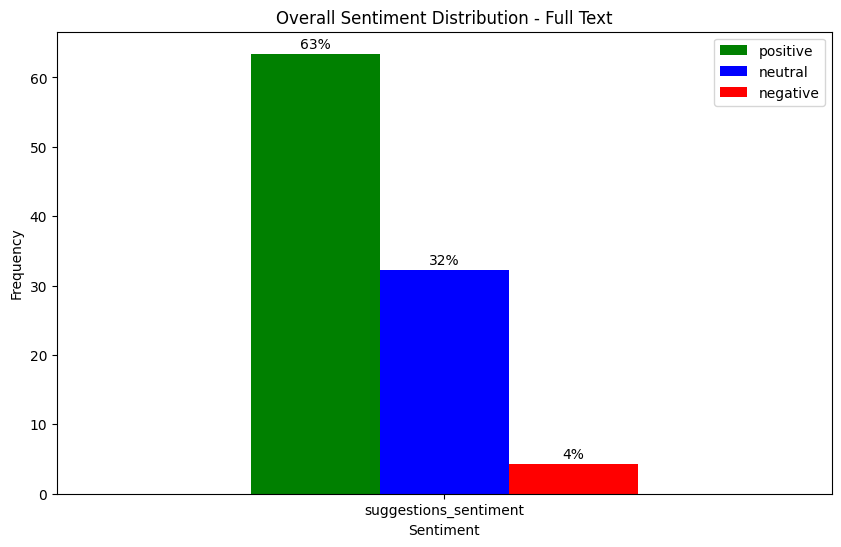

In [ ]:
plot_sentiment_distribution(df8_ss, "Full Text", is_percentage=True)

### PDF Research Data

#### CAMS


In [ ]:
text_2 = read_data("../assets/pdf/2022_lrec-1_686.pdf")
print(text_2)

Proceedings of the 13th Conference on Language Resources and Evaluation (LREC 2022), pages 6396 Marseille, 20-25 June 2022 European Language Resources Association (ELRA), licensed under CC-BY-NC-4.0 6387 CAMS An Annotated Corpus for Causal Analysis of Mental Health Issues in Social Media Posts Muskan Garg1,7, Chandni Saxena2, Veena Krishnan3, Ruchi Joshi4, Sriparna Saha5, Vijay Mago6, Bonnie J Dorr7 Thapar Institute of Engineering Technology, India, The Chinese University of Hong Kong, Hong Kong SAR, University of Petroleum And Energy Studies, India Amity University Rajasthan, India, Indian Institute of Technology, Patna, Lakehead University, Canada, University of Florida, USA. muskangarg, bonniejdorr ufl.edu, chandnisaxena cuhk.edu.hk, sriparna iitp.ac.in, vkrishnan ddn.upes.in, rjoshi jpr.amity.edu, vmago lakeheadu.ca Abstract Research community has witnessed substantial growth in the detection of mental health issues and their associated reasons from analysis of social media. We int

In [ ]:
text_2a = analyze_transformers(text_2)
df10 = pd.DataFrame(text_2a, columns=["sentiment"])
df10.head()

Classifying segment: Proceedings of the 13th Conference on Language Resources and Evaluation (LREC 2022), pages 6396 Mars...
Classifying segment:  model outperforms the next best (CNN-LSTM) model by 4.9% accuracy. Keywords clinical depression, cl...
Classifying segment:  social media since 2013 (Garg, 2021). However, there is minimal automation for identifying poten- t...
Classifying segment:  on the mental health of online users. Here, we consider three levels of mental disorder analysis fr...
Classifying segment:  3362 in- stances using our annotation schema. 3. Re-annotation of the existing SDCNL dataset as a r...
Classifying segment:  2018), and ex- plainability (Cao , 2019). Additional research directions have emerged from the use ...
Classifying segment:  but it is a starting point for our study, giving rise to five categories of reasons (plus no reason...
Classifying segment:  classify it into one of the predetermined categories y y0, y1, y2, y3, y4, y5 where y0 no rea- son ...


sentiment
0  {'label': 'neutral', 'score': 0.9191062450408936}
1  {'label': 'neutral', 'score': 0.6366575956344604}
2  {'label': 'negative', 'score': 0.6109152436256...
3  {'label': 'neutral', 'score': 0.8620724678039551}
4  {'label': 'neutral', 'score': 0.8488724231719971}

In [ ]:
list10 = df10["sentiment"].tolist()

In [ ]:
df10a = pd.DataFrame(aggregate_sentiments(list10), index=["sentiment_suggestions"])
df10a

positive  neutral  negative
sentiment_suggestions         1       21         4

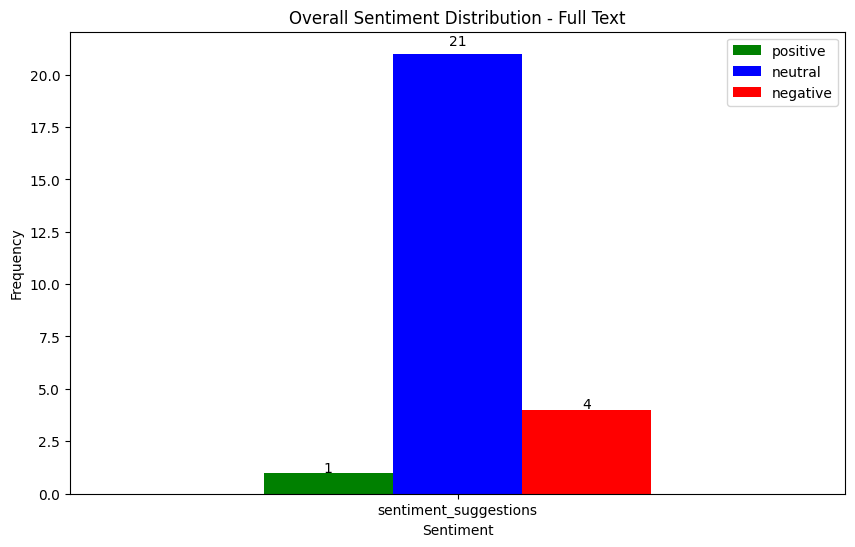

In [ ]:
plot_sentiment_distribution(df10a, "Full Text")

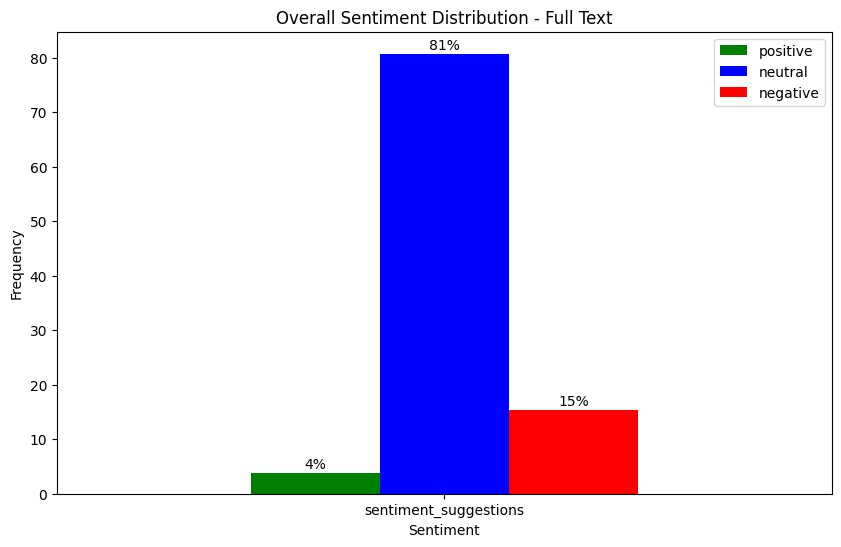

In [ ]:
plot_sentiment_distribution(df10a, "Full Text", is_percentage=True)

In [ ]:
text_3 = read_data("../assets/pdf/Glued-to-your-phone--Generation-Z-s-smartphone-addicti_2022_Computers-in-Hum.pdf")
print(text_3)

Computers in Human Behavior 136 (2022) 107404 Available online 15 July 2022 0747- 2022 The Authors. Published by Elsevier Ltd. This is an open access article under the CC BY license (http creativecommons.org licenses by 4. ). Glued to your phone Generation Z s smartphone addiction and online compulsive buying Michela Cesarina Mason a, Gioele Zamparo a, Andrea Marini b, Nisreen Ameen c, a University of Udine, Department of Economics and Statistics. Via Tomadini 30, Udine, 33100, Italy b University of Udine, Department of Languages and Literatures, Communication, Education and Society, Italy c School of Business and Management Royal Holloway, University of London, UK A R T I C L E I N F O Keywords Smartphone addiction Generation Z Compulsive buying S O-ARE Flow experience Mood regulation A B S T R A C T Recent studies found that smartphone usage has become an addiction nowadays, especially among young con sumers. The abuse of these digital devices affects individuals social life and well

In [ ]:
text_3a = analyze_transformers(text_3)
df11 = pd.DataFrame(text_3a, columns=["sentiment"])
df11.head()

Classifying segment: Computers in Human Behavior 136 (2022) 107404 Available online 15 July 2022 0747- 2022 The Authors. ...
Classifying segment:  changed various aspects of our lives (Ameen , a). Entertainment, work, social interactions and educ...
Classifying segment: ney , 2016). Altogether, this may facilitate the emergence and consequent satisfaction of those urge...
Classifying segment: roders, 2021). Thus, the current research contributes to the current body of knowledge in three ways...
Classifying segment:  addressed with considerations about future research. 2. Theoretical background 2.1. Generation Z Ge...
Classifying segment:  interna tional companies marketing activities, they share a common consumer culture and traits (Ben...
Classifying segment:  apps (AppAnnie, 2020), and the pandemic may have further reinforced this trend. Research addressing...
Classifying segment: ), and online mobile-related behaviour (Chan , 2017). Within this theoretical framework, a smartphon...


sentiment
0  {'label': 'neutral', 'score': 0.9256352186203003}
1  {'label': 'neutral', 'score': 0.8095691204071045}
2  {'label': 'neutral', 'score': 0.6241598129272461}
3  {'label': 'neutral', 'score': 0.6914841532707214}
4  {'label': 'neutral', 'score': 0.8440654873847961}

In [ ]:
list11 = df11["sentiment"].tolist()

In [ ]:
df11a = pd.DataFrame(aggregate_sentiments(list11), index=["sentiment_suggestions"])
df11a

positive  neutral  negative
sentiment_suggestions         0       54         0

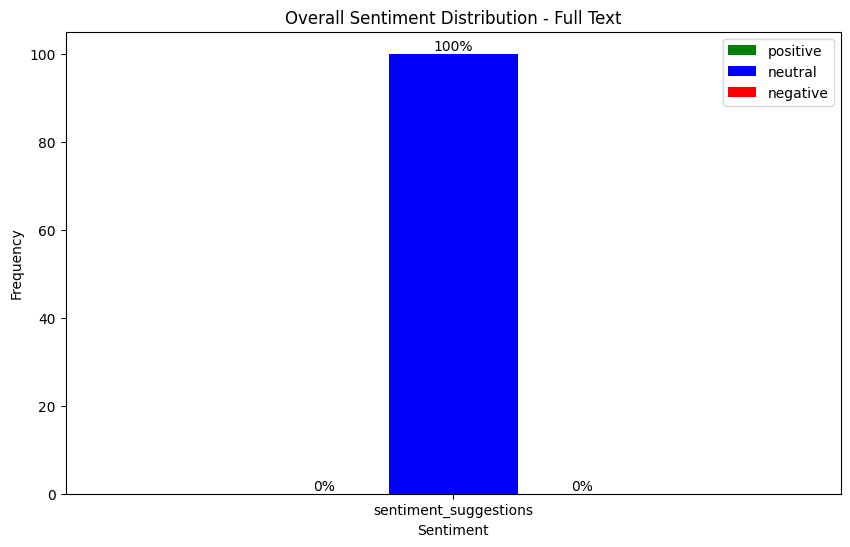

In [ ]:
plot_sentiment_distribution(df11a, "Full Text", is_percentage=True)

In [ ]:
def process_and_plot_sentiment(file_path):
    """
    This function reads a PDF file, analyzes sentiment using a transformer model,
    aggregates sentiment data, and plots the sentiment distribution.

    Args:
    file_path (str): Path to the PDF file containing the text to analyze.

    Returns:
    None: Outputs a graph showing sentiment distribution.
    """
    # Reading data from a PDF file
    text = read_data(file_path)

    # Analyzing sentiment using a pre-defined transformer model function
    text_a = analyze_transformers(text)

    # Converting results into a DataFrame
    df = pd.DataFrame(text_a, columns=["sentiment"])

    # Converting DataFrame column to a list
    list = df["sentiment"].tolist()

    # Aggregating sentiments using a pre-defined function
    aggregated_sentiments = aggregate_sentiments(list)
    dfa = pd.DataFrame(aggregated_sentiments, index=["0"])

    # Plotting the sentiment distribution using a pre-defined function
    plot_sentiment_distribution(dfa, "Full Text", is_percentage=True)

Classifying segment: Tasfi and Mostofa BMC Public Health (2024) 24 560 https doi.org 10. s12889-024-17989-x BMC Public He...
Classifying segment:  leading to an annual impact of more than 60 million people worldwide. Despite this, Correspondence ...
Classifying segment:  . The Creative Commons Public Domain Dedication waiver (http creativecommons.org publicdomain zero ...
Classifying segment:  and widows . However, Mashreky disagree with the above findings and show that most sui cide victims...
Classifying segment:  of food, lack of interest in customary activities, and a sharp and unexpected shift to a cheerful a...
Classifying segment:  study adopts an exploratory approach, employing in-depth expert interviews to comprehensively inves...
Classifying segment:  of World Religions and Culture, University of Dhaka, but waived the need for consent to participate...
Classifying segment:  times of crisis. People who are well-integrated with their families and communities benefit from th...


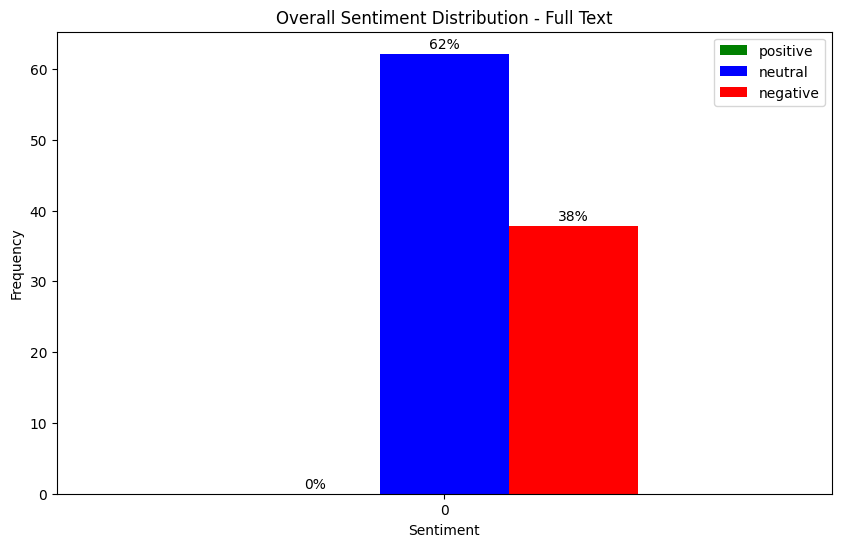

In [ ]:
file_path = "../assets/docx/suicidal_bangladesh.docx"

process_and_plot_sentiment(file_path)

Lets export the texts to text files for ingestion to the model phase.


In [ ]:
def export_columns_to_files(df, name, columns=None, directory="output_contracted"):

    # Ensure the output directory exists
    os.makedirs(directory, exist_ok=True)

    for column in columns:
        if column in df:
            base_filename = f"{name}_{column}.txt"
            filename = base_filename
            file_path = os.path.join(directory, filename)
            counter = 1

            # Check if the file already exists and modify the name if it does
            while os.path.exists(file_path):
                filename = f"{name}_{column}-{counter}.txt"
                file_path = os.path.join(directory, filename)
                counter += 1

            # Write the column data to the file
            with open(file_path, "w", encoding="utf-8") as file:
                for item in df[column].dropna():  # Drop NaN values
                    file.write(str(item) + ",")
            print(f"Data from column '{column}' has been written to {file_path}")
        else:
            print(f"Column '{column}' not found in DataFrame.")

In [ ]:
export_columns_to_files(df8, "Survey", ["suggestions"])

Data from column 'suggestions' has been written to output_contracted\Survey_suggestions.txt
